### Prosecution severity

##### Data:
1. case_offense_v01.csv (merged in bonds_analysis_01.ipynb, but ideally can be merged anywhere?)
2. ACIS_offence_codes_FIXED (from the 00_raw_data folder that Clarissa emailed)

##### Steps
1. Load Data 
    * Load the two files mentioned above

2. Merge charged and convicted codes with code descriptions
    * First, merge the "charged" code with code descriptions
    * Second, merge the output from the previous step and merge with the "convicted" code
    * **What does "Looks like some traffic infractions like Speeding dont get a class mean?"**
3. Data Quality Fixes
    * Fix Offense class strings ("1.0" to "1")
    * Impute clases with mode (**Even after imputation, "??" and NaN offenses remain**)

##### Steps:
1. (Done on separate script) Fix the NC Offense Codes dataset to capture codes that may have different classes in a separate column
2. Merge CHARGED and CONVICTED codes with the new NC Offense Codes to get classes and code descriptions
3. Marge CHARGED and CONVICTED offenses with the rank we make using the sentencing grid (just an ordering)
4. Once each offense has a "severity" associated, get the whole case deltas
5. Regression analiysis on AGGREGATES
6. Look at district court differences
7. Compare with system admissions (scatter plot)


#### 1. Load Data (takes ~4 mins)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

pd.set_option('display.max_columns', None) 
# I am blind without this
%config InlineBackend.figure_format = 'retina' 
offenses = pd.read_csv(
    "/workspaces/esg-controversy-tracker/nc_acis-main/20_intermediate_data/case_offense_v01.csv", #/Users/clarissaache/Documents/Capstone/case_offense_v01.csv
    low_memory=False,
    index_col=[0],
)
offense_desc_final = pd.read_csv('/workspaces/esg-controversy-tracker/nc_acis-main/20_intermediate_data/ACIS_offence_codes_FIXED.csv')

# subset
offs = offenses[
    [
        "case_id",
        "date_of_birth",
        "key_county_num",
        "key_year",
        "court_type",
        "race",
        "sex",
        "process_served",
        "case_creation_date",
        "case_trial_date",
        "court_attorney_type",
        "bond_type",
        "bond_amount",
        "charged_offense_date",
        "charged_offense_code",
        "offense_class",
        # "Offense Description",
        # "CL",
        #'T',
        "min_sentence",
        "convicted_offense_code",
        "disposition",
        "disposition_date",
    ]
]

offs["charge_count"] = 1
offs.sample(5)

/tmp/ipykernel_30385/1164588928.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offs["charge_count"] = 1


,case_id,date_of_birth,key_county_num,key_year,court_type,race,sex,process_served,case_creation_date,case_trial_date,court_attorney_type,bond_type,bond_amount,charged_offense_date,charged_offense_code,offense_class,min_sentence,convicted_offense_code,disposition,disposition_date,charge_count
3282390,1802020704277,95c809cdefa0df3077b3c821a9993272b55afa7cfbdc69...,180,20,CR,H,M,C,2020-10-04,2021-06-10,R,NaN,NaN,2020-10-03,5450,3,NaN,5450.0,JU,2021-06-10,1
11519985,5002020705356,ec19e4bfd6fb46f8bcc91c0818c3f616321e1c0019dbd0...,500,20,CR,W,M,C,2020-03-27,2020-11-13,NaN,NaN,NaN,2020-03-27,5487,NaN,NaN,NaN,VD,2021-03-30,1
8717615,4002013717041,8b2d4da61a9a67299514123a712199ca7d80aa39f7c683...,400,13,CR,B,F,C,2013-05-30,2013-08-29,NaN,NaN,NaN,2013-05-30,5494,NaN,NaN,NaN,VD,2013-08-29,1
20975693,9102014724251,70cfc840f73f46231212cb35d072373fe94408d321924e...,910,14,CR,W,M,C,2014-04-22,2014-06-03,W,NaN,NaN,2014-04-22,4450,NaN,NaN,4450.0,JU,2014-06-03,1
22047524,9302013700328,9c4c6c3e6b8e3e3e626fa3e65b25a81f4f03613bc2b96b...,930,13,CR,O,M,C,2013-04-24,2013-07-09,R,NaN,NaN,2013-04-24,5418,1,2.0,5418.0,JU,2013-07-09,1


### 2. Merge CHARGED and CONVICTED codes with Code Descriptions

In [2]:
# rename cols
offense_desc_2 = offense_desc_final.rename(
    columns={
        "Offense Description": "charg_Off_Desc",
        "CODE": "charg_CODE",
        "T": "charg_type",
        "NC General Statute": "charg_statute",
        "CL_min": "charg_CL_min",
        "CL_Rank_min": "charg_CL_Rank_min",
        "CL_max": "charg_CL_max",
        "CL_Rank_max": "charg_CL_Rank_max",
    },
)

# merge
offs_rank = pd.merge(
    left=offs,
    right=offense_desc_2,
    left_on="charged_offense_code",
    right_on="charg_CODE",
    how="left",
    validate="m:m"
)

# Merge with offence code CONVICTED descriptions:
# rename cols
offense_desc_1 = offense_desc_final.rename(
    columns={
        "Offense Description": "conv_Off_Desc",
        "CODE": "conv_CODE",
        "T": "convc_type",
        "NC General Statute": "conv_statute",
        "CL_min": "conv_CL_min",
        "CL_Rank_min": "conv_CL_Rank_min",
        "CL_max": "conv_CL_max",
        "CL_Rank_max": "conv_CL_Rank_max",
    },
)

# merge
offs_rank = pd.merge(
    left=offs_rank,
    right=offense_desc_1,
    left_on="convicted_offense_code",
    right_on="conv_CODE",
    how="left",
    validate="m:m"
)


### 3. Data Quality Fixes

In [3]:
# lets fix the Offense Class column
offs_rank.loc[offs_rank["offense_class"] == "1.0", "offense_class"] = "1"
offs_rank.loc[offs_rank["offense_class"] == "2.0", "offense_class"] = "2"
offs_rank.loc[offs_rank["offense_class"] == "3.0", "offense_class"] = "3"
offs_rank.loc[offs_rank["offense_class"] == "i", "offense_class"] = "I"

In [4]:
# impute classes with mode for each offense code
mode_classes = pd.DataFrame(offs_rank.groupby('charged_offense_code')['offense_class'].agg(lambda x: pd.Series.mode(x))).reset_index()
mode_classes['offense_class'] = mode_classes['offense_class'].astype('str')
mode_classes.loc[mode_classes['offense_class'].str.contains("]"), 'offense_class']=np.nan
mode_classes.rename(columns={'offense_class':'offense_class_MODE'}, inplace=True)

# merge
offs_rank = pd.merge(
    left=offs_rank,
    right=mode_classes,
    on='charged_offense_code',
    how="left",
    validate="m:m",
    indicator=True,
)

In [5]:
offs_rank.loc[offs_rank['offense_class']==" ", 'offense_class']=np.nan 
offs_rank.loc[offs_rank['offense_class']=="??", 'offense_class']=np.nan
offs_rank["offense_class"] = offs_rank["offense_class"].fillna(offs_rank["offense_class_MODE"])
# impute the rest with the statute class (I am going to use max, and I refuse to explain it to you)
offs_rank["offense_class"] = offs_rank["offense_class"].fillna(offs_rank["charg_CL_max"])

In [7]:
# Clean up sex:
offs_rank.sex.value_counts()
offs_rank = offs_rank[offs_rank["sex"].isin(["M", "F", "U"])] # get rid of the X category, only 500 offenses 

### 4. Data Processing (Severity #1: Class ranks

In [8]:
# create ranks for classes
class_ranks = {
    "0": 0,
    "3": 1,
    "2": 2,
    "1": 3,
    "A1": 4,
    "I": 5,
    "H": 6,
    "G": 7,
    "F": 8,
    "E": 9,
    "D": 10,
    "C": 11,
    "B2": 12,
    "B1": 13,
    "A": 14,
    "??": np.nan,
}
class_ranks = pd.DataFrame.from_dict(class_ranks, "index").reset_index()
class_ranks.rename(columns={0: "CL_Rank"}, inplace=True)

#merge
offs_rank = pd.merge(offs_rank, class_ranks, left_on="offense_class", right_on="index", how="left")  # now, 'CL_rank' is the rank of the charged offense class provided by the court

# NOW lets look at deltas at the offense level for a second
offs_rank["delta_min"] = (offs_rank["conv_CL_Rank_min"] - offs_rank["CL_Rank"])  
#
# DELTA = final - initial, Delta MIN is the one using the minimum ranking of the convicted offense (when it can belong in two or more classes
# This means delta_min will be probably a larger delta than delta max
#
offs_rank["delta_max"] = offs_rank["conv_CL_Rank_max"] - offs_rank["CL_Rank"]

offs_rank.loc[offs_rank["conv_CL_min"] == "??", "charg_Off_Desc"].value_counts()


charg_Off_Desc
DRIVING WHILE IMPAIRED            296361
INJURY TO PERSONAL PROPERTY        24739
SHOPLIFTING CONCEALMENT GOODS      23171
CRIMINAL CONTEMPT                  18234
DANGEROUS DRUGS - FREE TEXT        14193
                                   ...  
FORGERY OF DEEDS OR WILLS              1
DWI - AGGRAVATED LEVEL 1               1
INTERFERE WITH UTILITY METER           1
DISCHARGE FIREARM ON EDUC PROP         1
ASSAULT HANDICAPPED PERSON             1
Name: count, Length: 957, dtype: int64

In [9]:
# if codes are the same, fill NaN with 0
offs_rank.loc[
    offs_rank["charged_offense_code"] == offs_rank["convicted_offense_code"],
    "delta_min",
] = 0
offs_rank.loc[
    offs_rank["charged_offense_code"] == offs_rank["convicted_offense_code"],
    "delta_max",
] = 0


5. Analysis

In [10]:
# averages
offs_rank[["race", "delta_max", "delta_min"]].groupby(
    "race"
).mean().reset_index()  # whites are getting a drop in offense class that is higher than blacks and hispanics, asians see the highest drop


,race,delta_max,delta_min
0,A,-0.684631,-0.683998
1,B,-0.356658,-0.343860
2,H,-0.353413,-0.342576
3,I,-0.220915,-0.215090
4,O,-0.605199,-0.598263
5,U,-0.104833,-0.108508
6,W,-0.409828,-0.406411


In [11]:
# CONCLUSION 2

#offs_rank.loc[offs_rank["race"].isin(["I", "O", "U"]), "race"] = "Other"
offs_rank[["race", "delta_max", "delta_min"]].groupby("race").mean().reset_index()


,race,delta_max,delta_min
0,A,-0.684631,-0.683998
1,B,-0.356658,-0.343860
2,H,-0.353413,-0.342576
3,I,-0.220915,-0.215090
4,O,-0.605199,-0.598263
5,U,-0.104833,-0.108508
6,W,-0.409828,-0.406411


In [14]:
import statsmodels.formula.api as smf

# delta is the initial minus the final
m = smf.ols("delta_min ~ race + sex", offs_rank).fit()
m.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delta_min   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 1.804e+04
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:08:54   Log-Likelihood:            -4.1458e+06
No. Observations:             5284079   AIC:                         8.292e+06
Df Residuals:                 5284070   BIC:                         8.292e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7800      0.003   -295.689      0.000      -0.785      -0.775
race[T.B]      0.3384      0.003    127.949      0.000       0.333       0.344
race[T.H]      0.3340      0.003    123.729      0.000       0.329       0.339
race[T.I]      0.4695      0.003    142.272      0.000       0.463       0.476
race[T.O]      0.0824      0.003     27.312      0.000       0.076       0.088
race[T.U]      0.5555      0.005    119.629      0.000       0.546       0.565
race[T.W]      0.2807      0.003    106.482      0.000       0.276       0.286
sex[T.M]       0.1399      0.000    280.972      0.000       0.139       0.141
sex[T.U]       0.2211      0.009     23.710      0.000       0.203       0.239
==============================================================================
Omnibus:                   854088.126   Durbin-Watson:                   1.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1726247.679
Skew:                          -0.986   Prob(JB):                         0.00
Kurtosis:                       4.988   Cond. No.                         56.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Try Rank based on min sentence length

In [26]:
from sklearn.preprocessing import MinMaxScaler

# group by convicted offense and scale
p_ranks = (
    offenses[["convicted_offense_code", "min_sentence_day"]]
    .groupby("convicted_offense_code")
    .mean()
    .reset_index()
)
p_ranks["offense_rank"] = MinMaxScaler().fit_transform(
    np.array(p_ranks["min_sentence_day"]).reshape(-1, 1))

p_ranks = p_ranks.loc[~p_ranks['offense_rank'].isna()]


In [27]:
offense_desc_3 = offense_desc_final.rename(
    columns={
        "Offense Description": "Off_Desc",
        "CODE": "offense_code",
        "T": "type",
        "NC General Statute": "statute",
    },
)
offense_desc_3 = offense_desc_3.drop('Unnamed: 0', axis=1)
offense_desc_3.dtypes

offense_code      int64
Off_Desc         object
type             object
statute          object
CL_min           object
CL_Rank_min     float64
CL_max           object
CL_Rank_max     float64
dtype: object

In [28]:
# are the two ranking approaches different?
severity_comp = pd.merge(p_ranks, offense_desc_3, left_on='convicted_offense_code', right_on='offense_code',how='right', validate='m:m', indicator=True)
severity_comp._merge.value_counts()

_merge
both          1404
right_only     707
left_only        0
Name: count, dtype: int64

In [29]:
severity_comp = severity_comp.loc[severity_comp['_merge']=="both"]
severity_comp = severity_comp.rename(
    columns={
        "Offense Description": "off_desc",
        "min_sentence":"min_sentence_Rank"
    },
)
severity_comp.sort_values(['offense_rank', 'CL_Rank_min'], ascending=False) # the ranks are different! rape and child-related stuff is worse in the min sentence driven scale. i get that

,convicted_offense_code,min_sentence_day,offense_rank,offense_code,Off_Desc,type,statute,CL_min,CL_Rank_min,CL_max,CL_Rank_max,_merge
605,3633.0,9510.000000,1.000000,3633,INCEST CHILD 13/14/15 DEF> 4<6,F,14-178(B)(2),C,11.0,C,11.0,both
638,3635.0,9147.096774,0.961836,3635,RAPE OF A CHILD,F,14-27.2A(A),B1,13.0,B1,13.0,both
641,3641.0,8820.681818,0.927509,3641,STAT SEX OFF W/CHILD BY ADULT,F,14-27.28,B1,13.0,B1,13.0,both
626,1104.0,8812.500000,0.926648,1104,FIRST DEGREE FORCIBLE RAPE,F,14-27.21,B1,13.0,B1,13.0,both
639,3636.0,8678.382353,0.912544,3636,SEXUAL OFFENSE WITH A CHILD,F,14-27.4A(A),B1,13.0,B1,13.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...
1133,4483.0,1.000000,0.000000,4483,ILLEGAL PARKING,I,20-162.1,0,0.0,0,0.0,both
1147,4497.0,1.000000,0.000000,4497,HANDICAPPED PARKING VIOLATION,I,20-37.6(E),0,0.0,0,0.0,both
1193,4551.0,1.000000,0.000000,4551,ILLEGAL RIGHT TURN ON RED,I,20-158(B)(2)(A),0,0.0,0,0.0,both
1194,4552.0,1.000000,0.000000,4552,IMPROPER PASSING ON RIGHT,I,20-150.1,0,0.0,0,0.0,both


In [31]:
# merge with existing CONVICTED off code

if "_merge" in offs_rank.columns:
    offs_rank = offs_rank.drop("_merge", axis=1)
offs_rank2 = pd.merge(
    offs_rank,
    p_ranks[['convicted_offense_code', 'offense_rank']],
    how="left",
    on="convicted_offense_code",
    validate="m:m",
    indicator=True,
)
offs_rank2._merge.value_counts()


_merge
left_only     17329271
both           5594175
right_only           0
Name: count, dtype: int64

In [33]:
# merge with existing CHARGED off code
offs_rank2.drop("_merge", axis=1, inplace=True)
p_ranks.rename(
    columns={
        "convicted_offense_code": "charged_offense_code",
        "offense_rank": "charged_offense_rank",
    },
    inplace=True,
)
offs_rank2 = pd.merge(
    offs_rank2,
    p_ranks[['charged_offense_code', 'charged_offense_rank']],
    how="left",
    on="charged_offense_code",
    validate="m:m",
    indicator=True,
)
offs_rank2._merge.value_counts()


_merge
both          22232428
left_only       691018
right_only           0
Name: count, dtype: int64

In [34]:
# NOW lets look at the delta (again)!

offs_rank2.loc[
    offs_rank2["charged_offense_code"] == offs_rank2["convicted_offense_code"], "delta2"
] = 0


offs_rank2["delta2"] = offs_rank2["offense_rank"] -  offs_rank2["charged_offense_rank"] # convicted - charged

print(offs_rank2["delta2"].mean())

# pick a better name, better scale:
offs_rank2 = offs_rank2.rename(columns={'offense_rank':"conv_off_severity" ,'charged_offense_rank':'charg_off_severity'})


offs_rank2["delta2"].median()

-0.0017939187370494237


0.0

In [35]:
offs_rank2['conv_off_severity']=offs_rank2['conv_off_severity']*100
offs_rank2['charg_off_severity']=offs_rank2['charg_off_severity']*100

,delta_max,delta_min,delta2
race,,,
A,-0.684631,-0.683998,-0.000856
B,-0.356658,-0.343860,-0.002195
H,-0.353413,-0.342576,-0.000872
I,-0.220915,-0.215090,-0.001668
O,-0.605199,-0.598263,-0.000636
U,-0.104833,-0.108508,-0.003693
W,-0.409828,-0.406411,-0.001790


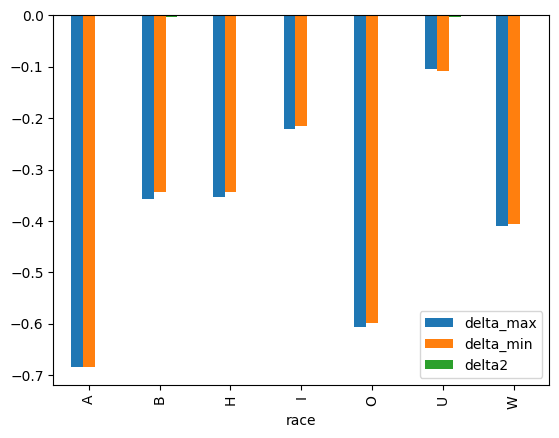

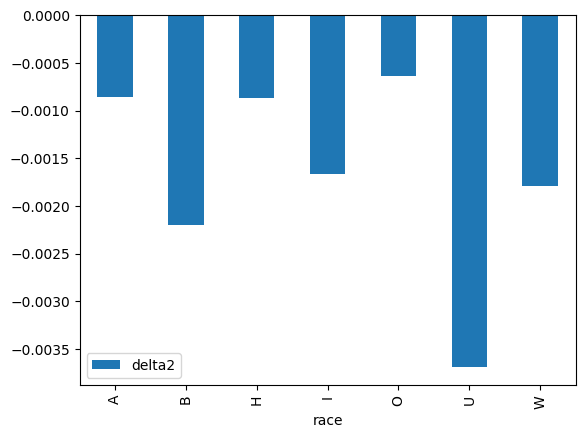

In [36]:
offs_rank2[["race", "delta_max", "delta_min", "delta2"]].groupby("race").mean().plot(kind='bar')
offs_rank2[["race","delta2"]].groupby("race").mean().plot(kind='bar')
# it is always negative, so the procecutors will negotiate a less severe sentence for you to plead guilty
offs_rank2[["race", "delta_max", "delta_min", "delta2"]].groupby("race").mean()
# i guess delta min and delta max are not that different...
# NEED TO LOOK AT RELATIVE DISTANCE

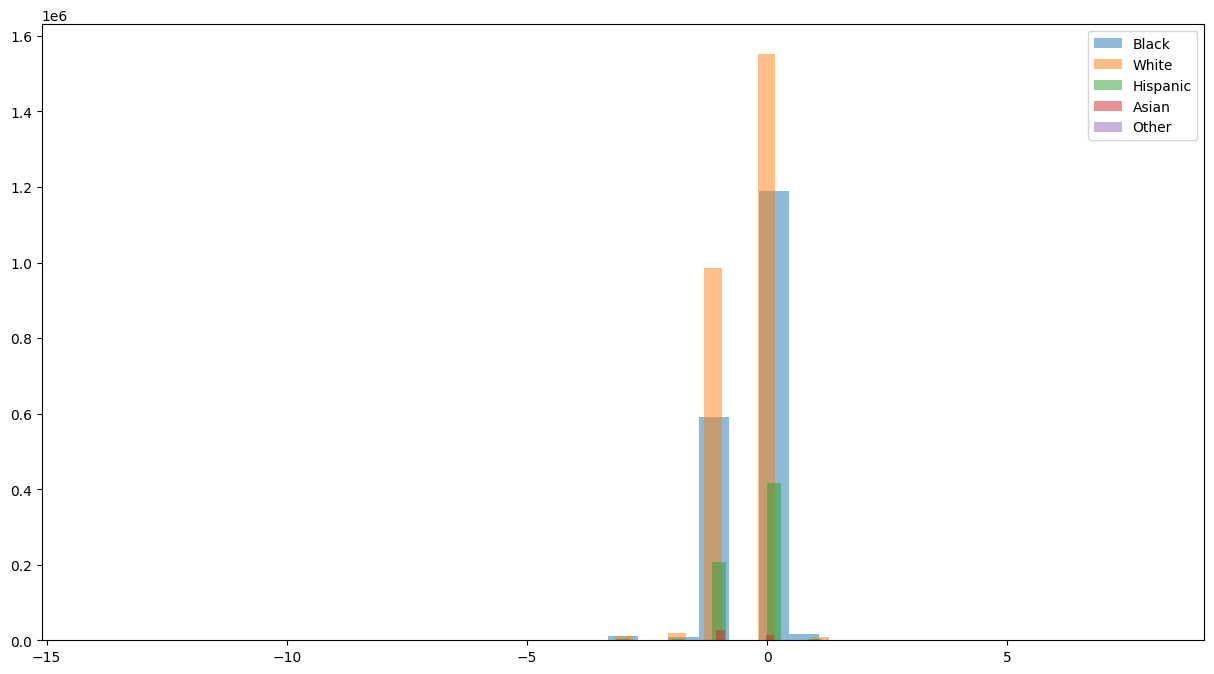

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8))
bins = 35

plt.hist(offs_rank2.loc[offs_rank2['race']=='B', 'delta_min'], bins, alpha=0.5, label='Black')
plt.hist(offs_rank2.loc[offs_rank2['race']=='W', 'delta_min'], bins, alpha=0.5, label='White')
plt.hist(offs_rank2.loc[offs_rank2['race']=='H', 'delta_min'], bins, alpha=0.5, label='Hispanic')
plt.hist(offs_rank2.loc[offs_rank2['race']=='A', 'delta_min'], bins, alpha=0.5, label='Asian')
plt.hist(offs_rank2.loc[offs_rank2['race']=='Other', 'delta_min'], bins, alpha=0.5, label='Other')
plt.legend(loc='upper right')

plt.show() #not very helpful

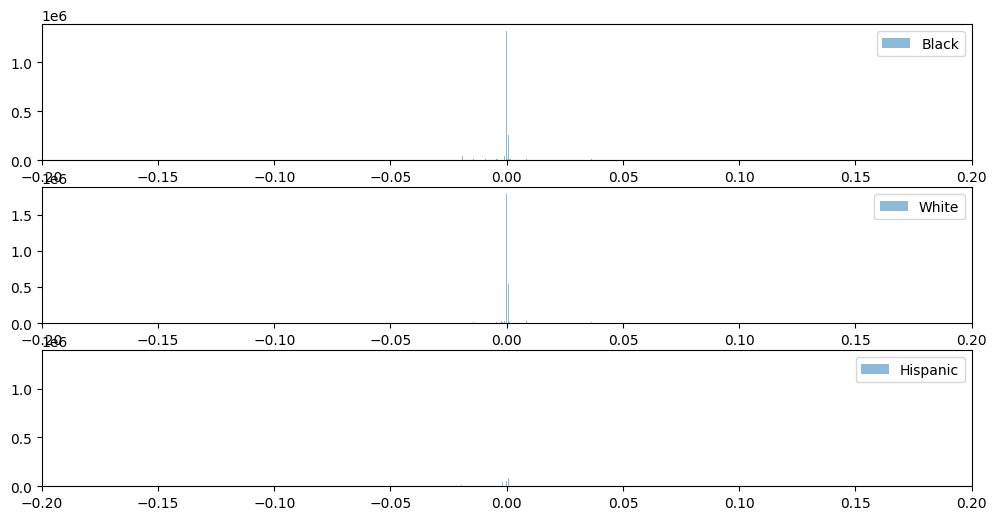

In [38]:
# trying different plots
bins = 5000
fig = plt.figure(figsize=(12, 6))

ax1 = plt.subplot(311)
plt.hist(offs_rank2.loc[offs_rank2['race']=='B', 'delta2'], bins, alpha=0.5, label='Black')
plt.legend(loc='upper right')

ax2 = plt.subplot(312, sharex=ax1)
plt.hist(offs_rank2.loc[offs_rank2['race']=='W', 'delta2'], bins, alpha=0.5, label='White')
plt.legend(loc='upper right')

ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.hist(offs_rank2.loc[offs_rank2['race']=='H', 'delta2'], bins, alpha=0.5, label='Hispanic')


#plt.hist(offs_rank2.loc[offs_rank2['race']=='A', 'delta100'], bins, alpha=0.5, label='Asian')
#plt.hist(offs_rank2.loc[offs_rank2['race']=='Other', 'delta100'], bins, alpha=0.5, label='Other')

ax1.set_xlim(-.2,.2)

plt.legend(loc='upper right')
plt.show()

In [39]:
offs_rank2[
    [
        "charged_offense_code",
        "charg_type",
        "charg_Off_Desc",
        "offense_class",
        "convc_type",
        "convicted_offense_code",
        "conv_Off_Desc",
        "conv_CL_min",
        "conv_CL_max",
        "CL_Rank",
        "conv_CL_Rank_min",
        "conv_CL_Rank_max",
        "charg_off_severity",
        "conv_off_severity",
    ]
].sample(5)
# there are still some NaN


,charged_offense_code,charg_type,charg_Off_Desc,offense_class,convc_type,convicted_offense_code,conv_Off_Desc,conv_CL_min,conv_CL_max,CL_Rank,conv_CL_Rank_min,conv_CL_Rank_max,charg_off_severity,conv_off_severity
2024507,3401,M,POSSESS DRUG PARAPHERNALIA,1,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,0.529405,NaN
14387849,5450,T,SPEEDING,3,I,4418.0,IMPROPER EQUIP - SPEEDOMETER,0,0,1.0,0.0,0.0,0.244883,0.316300
11091310,4440,I,EXPIRED/NO INSPECTION,3,I,4440.0,EXPIRED/NO INSPECTION,0,0,1.0,0.0,0.0,0.221895,0.221895
13643057,5441,T,NO OPERATORS LICENSE,3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.247197,NaN
1336462,5418,T,DWLR,1,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,0.695763,NaN


# Lets look at cases

In [40]:
convicted_off_ranks = offs_rank2[
    [
        "case_id",
        "date_of_birth",
        "charged_offense_code",
        "charg_type",
        #"charg_Off_Desc",
        "CL_Rank",
        #"convicted_offense_code",
        "conv_Off_Desc"	,
        "conv_CL_Rank_min",
        "conv_CL_Rank_max", 
        "charg_off_severity",
        "conv_off_severity",
    ]
]  # only cases that have convicted codes

cases_delta_code = pd.merge(
    offenses,
    convicted_off_ranks,
    how="left",
    on=["case_id", "date_of_birth", "charged_offense_code"],
    validate="m:m",
    indicator=True,
)
cases_delta_code._merge.value_counts()




_merge
both          27779508
left_only       115958
right_only           0
Name: count, dtype: int64

In [44]:
# Class driven rank
cases_delta_code.loc[cases_delta_code["convicted_offense_code"].isna(), "conv_CL_Rank_max"] = 0
cases_delta_code.loc[cases_delta_code["convicted_offense_code"].isna(), "conv_CL_Rank_min"] = 0


#cases_delta_code.loc[cases_delta_code["CL_Rank"].isna(), "CL_Rank"] = 0 <----------THIS IS WRONG

# min sentence driven rank
cases_delta_code.loc[cases_delta_code["charged_offense_code"].isna(), "charg_off_severity"] = 0
cases_delta_code.loc[cases_delta_code["convicted_offense_code"].isna(), "conv_off_severity"] = 0


In [45]:
cases_delta_code.loc[cases_delta_code["case_id"] == 9701997010276][['conv_off_severity', 'charg_off_severity',"CL_Rank","conv_CL_Rank_min", 'disposition']]
#cases_delta_code.shape


,conv_off_severity,charg_off_severity,CL_Rank,conv_CL_Rank_min,disposition
27456740,0.000000,22.102014,8.0,0.0,SI
27456741,0.000000,22.102014,8.0,0.0,SI
27456742,NaN,22.102014,8.0,NaN,JU
27456743,6.084765,22.102014,8.0,8.0,JU
27456744,0.000000,2.379267,1.0,0.0,PO


In [46]:
cases_delta_code.CL_Rank.value_counts()

CL_Rank
1.0     12130026
3.0      4272143
2.0      3091537
6.0      2904904
5.0      1808261
4.0       712551
7.0       575535
8.0       543877
9.0       339082
0.0       162246
10.0      148631
13.0      102673
11.0       99669
12.0       43338
14.0        1077
Name: count, dtype: int64

In [47]:
CASEZ = (
    cases_delta_code[
        [
            "CL_Rank",
            "conv_CL_Rank_min",
            "conv_off_severity",
            "charg_off_severity",
            "case_id",
            #'prior_record_points'
        ]
    ]
    .groupby(by="case_id")
    .sum()
    .reset_index()
)
# relative change
CASEZ["case_DELTA_cl_perc"] = (CASEZ["conv_CL_Rank_min"] - CASEZ["CL_Rank"])*100/(CASEZ["CL_Rank"])
CASEZ["case_DELTA_ms_perc"] = (CASEZ["conv_off_severity"] - CASEZ["charg_off_severity"])*100/(CASEZ["charg_off_severity"])

# relative change (using average as denominator bc there are 0s)
CASEZ["case_DELTA_cl_rel"] = (CASEZ["conv_CL_Rank_min"] - CASEZ["CL_Rank"])/((CASEZ["CL_Rank"]+CASEZ["conv_CL_Rank_min"])/2)
CASEZ["case_DELTA_ms_rel"] = (CASEZ["conv_off_severity"] - CASEZ["charg_off_severity"])/((CASEZ["conv_off_severity"]+CASEZ["charg_off_severity"])/2)
CASEZ.loc[CASEZ.case_DELTA_cl_rel.isna()]

# fix the nas:
CASEZ.loc[(CASEZ['CL_Rank'] == 0) & (CASEZ['conv_CL_Rank_min']==0), 'case_DELTA_cl_rel']=0
CASEZ.loc[(CASEZ['conv_off_severity'] == 0) & (CASEZ['charg_off_severity']==0), 'case_DELTA_ms_rel']=0

# total change
CASEZ["case_DELTA_cl"] = CASEZ["conv_CL_Rank_min"] - CASEZ["CL_Rank"]
CASEZ["case_DELTA_ms"] = CASEZ["conv_off_severity"] - CASEZ["charg_off_severity"]

CASEZ.sample(20)
#BOOM

,case_id,CL_Rank,conv_CL_Rank_min,conv_off_severity,charg_off_severity,case_DELTA_cl_perc,case_DELTA_ms_perc,case_DELTA_cl_rel,case_DELTA_ms_rel,case_DELTA_cl,case_DELTA_ms
9794618,6702017708166,2.0,0.0,0.348057,0.428411,-100.000000,-18.756177,-2.000000,-0.206972,-2.0,-0.080353
7694688,5902013001704,1.0,0.0,0.232781,0.244883,-100.000000,-4.941974,-2.000000,-0.050672,-1.0,-0.012102
4148649,3302016003400,0.0,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.0,0.000000
3729591,3202013700824,2.0,2.0,0.183528,0.940646,0.000000,-80.489171,0.000000,-1.346977,0.0,-0.757118
7283328,5502014701476,2.0,0.0,0.232781,0.492080,-100.000000,-52.694513,-2.000000,-0.715445,-2.0,-0.259299
8900623,6202018701654,1.0,0.0,0.316300,0.244883,-100.000000,29.163564,-2.000000,0.254522,-1.0,0.071417
5802803,4102017001554,1.0,0.0,0.000000,0.153705,-100.000000,-100.000000,-2.000000,-2.000000,-1.0,-0.153705
13786086,9602013704050,1.0,0.0,0.316300,0.244883,-100.000000,29.163564,-2.000000,0.254522,-1.0,0.071417
6720281,5002013054074,10.0,0.0,0.000000,4.452607,-100.000000,-100.000000,-2.000000,-2.000000,-10.0,-4.452607
9033811,6302016002211,2.0,0.0,0.556547,3.694347,-100.000000,-84.935177,-2.000000,-1.476301,-2.0,-3.137800


In [48]:
CASEZ.loc[CASEZ["case_id"] == 9002014000957]

,case_id,CL_Rank,conv_CL_Rank_min,conv_off_severity,charg_off_severity,case_DELTA_cl_perc,case_DELTA_ms_perc,case_DELTA_cl_rel,case_DELTA_ms_rel,case_DELTA_cl,case_DELTA_ms
12226664,9002014000957,2.0,0.0,0.169272,1.854207,-100.0,-90.870925,-2.0,-1.665384,-2.0,-1.684935


<Axes: title={'center': 'Frequency of Relative Change in Severity of Cases\n(using the Class-based Approach and Empirical Approach)'}, xlabel='Relative Change in Severity of Cases', ylabel='Frequency of Cases'>

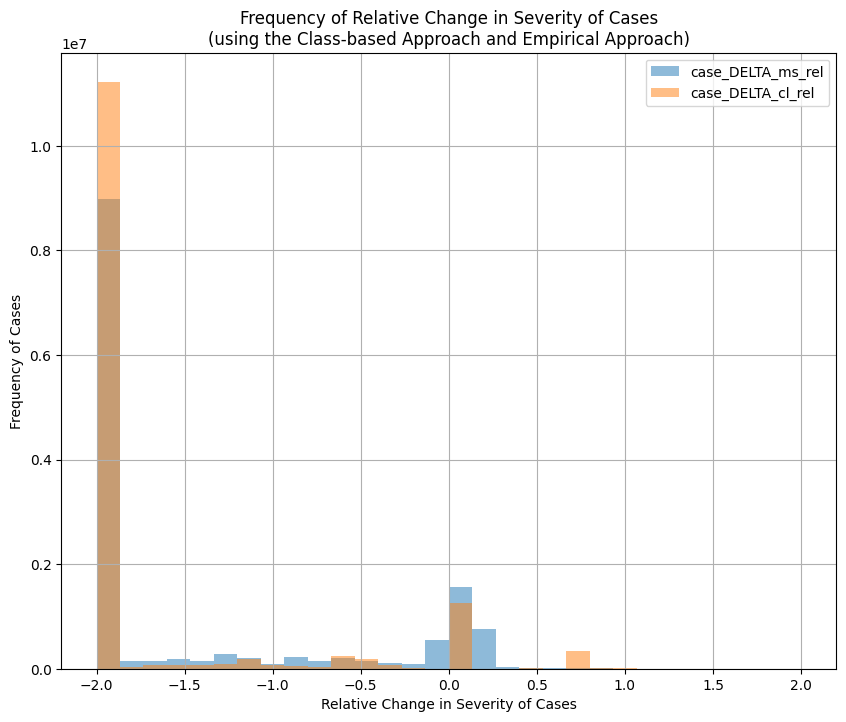

In [49]:
Empirical_Approach = CASEZ.case_DELTA_ms_rel
Class_Based_Approach = CASEZ.case_DELTA_cl_rel

plt.figure(figsize=(10,8))

plt.title('Frequency of Relative Change in Severity of Cases\n(using the Class-based Approach and Empirical Approach)')
plt.xlabel('Relative Change in Severity of Cases')
plt.ylabel('Frequency of Cases')

Empirical_Approach.hist(alpha=0.5, bins= 30,legend=True)
Class_Based_Approach.hist(alpha=0.5, bins= 30,legend=True)


In [50]:
cases_info = offenses[ #<------- HAS TO BE THE ORIGINAL DATASET bc offs has only convicted offenses
    [
        "case_id",
        "date_of_birth",
        "key_county_num",
        "key_year",
        "court_type",
        "race",
        "sex",
        "process_served",
        "case_creation_date",
        "court_attorney_type",
        "bond_type",
        "bond_amount",
        "charged_offense_code",
        "convicted_offense_code",
        "offense_class", #new
        "disposition",
        "court_cost",
        "prior_record_points",
        "judge_code",
        "plea_code",
        "verdict_code",
        "court_type",
        'def_zip_address',
    ]
]

cases_info.sample(2) 

,case_id,date_of_birth,key_county_num,key_year,court_type,race,sex,process_served,case_creation_date,court_attorney_type,bond_type,bond_amount,charged_offense_code,convicted_offense_code,offense_class,disposition,court_cost,prior_record_points,judge_code,plea_code,verdict_code,court_type,def_zip_address
22151766,9402018050554,4d9ac6c4a1f781a46f0aaf1e2072911f1005305fef568b...,940,18,CR,W,F,M,2018-04-18,A,SEC,5000.0,3540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CR,28607
5390287,2802020702437,39631f6c0691680e2ed38e45336e2ace4388825654ff43...,280,20,CR,W,M,C,2020-03-06,NaN,NaN,NaN,5450,NaN,NaN,VD,NaN,NaN,NaN,NaN,NaN,CR,29063


In [51]:
len(cases_info.case_id.unique())

14081546

In [52]:
cases_info.loc[~cases_info.plea_code.isna()].plea_code.value_counts(normalize=True, dropna=False)*100

plea_code
GU    47.866144
RL    34.255696
GL     5.349246
RS     4.978771
NG     4.532285
GA     1.627256
NC     1.139484
NR     0.221262
OT     0.029856
Name: proportion, dtype: float64

In [53]:
cases_info.loc[cases_info["case_id"] == 9701997010276]

,case_id,date_of_birth,key_county_num,key_year,court_type,race,sex,process_served,case_creation_date,court_attorney_type,bond_type,bond_amount,charged_offense_code,convicted_offense_code,offense_class,disposition,court_cost,prior_record_points,judge_code,plea_code,verdict_code,court_type,def_zip_address
22700100,9701997010276,bff266141526daf6bdce5356c965185b32f278f8c6fd54...,970,97,CRS,W,F,W,1997-07-25,A,NaN,NaN,1199,NaN,NaN,SI,NaN,NaN,NaN,NaN,NaN,CRS,NaN
22700101,9701997010276,bff266141526daf6bdce5356c965185b32f278f8c6fd54...,970,97,CRS,W,F,W,1997-07-25,A,NaN,NaN,1199,1118.0,NaN,JU,111.0,NaN,GKB,GL,GU,CRS,NaN
22700102,9701997010276,bff266141526daf6bdce5356c965185b32f278f8c6fd54...,970,97,CRS,W,F,W,1997-07-25,A,NaN,NaN,5099,NaN,NaN,PO,NaN,NaN,MFF,NaN,NaN,CRS,NaN


In [54]:
case_delta_analysis = pd.merge(
    cases_info, CASEZ, how="left", on="case_id", validate="m:m", indicator=True
)
case_delta_analysis._merge.value_counts()


_merge
both          23039404
left_only            0
right_only           0
Name: count, dtype: int64

In [55]:

case_delta_analysis.loc[case_delta_analysis["case_id"] == 9701997010276]

,case_id,date_of_birth,key_county_num,key_year,court_type,race,sex,process_served,case_creation_date,court_attorney_type,bond_type,bond_amount,charged_offense_code,convicted_offense_code,offense_class,disposition,court_cost,prior_record_points,judge_code,plea_code,verdict_code,court_type,def_zip_address,CL_Rank,conv_CL_Rank_min,conv_off_severity,charg_off_severity,case_DELTA_cl_perc,case_DELTA_ms_perc,case_DELTA_cl_rel,case_DELTA_ms_rel,case_DELTA_cl,case_DELTA_ms,_merge
22700100,9701997010276,bff266141526daf6bdce5356c965185b32f278f8c6fd54...,970,97,CRS,W,F,W,1997-07-25,A,NaN,NaN,1199,NaN,NaN,SI,NaN,NaN,NaN,NaN,NaN,CRS,NaN,33.0,8.0,6.084765,90.787324,-75.757576,-93.297781,-1.219512,-1.748751,-25.0,-84.702559,both
22700101,9701997010276,bff266141526daf6bdce5356c965185b32f278f8c6fd54...,970,97,CRS,W,F,W,1997-07-25,A,NaN,NaN,1199,1118.0,NaN,JU,111.0,NaN,GKB,GL,GU,CRS,NaN,33.0,8.0,6.084765,90.787324,-75.757576,-93.297781,-1.219512,-1.748751,-25.0,-84.702559,both
22700102,9701997010276,bff266141526daf6bdce5356c965185b32f278f8c6fd54...,970,97,CRS,W,F,W,1997-07-25,A,NaN,NaN,5099,NaN,NaN,PO,NaN,NaN,MFF,NaN,NaN,CRS,NaN,33.0,8.0,6.084765,90.787324,-75.757576,-93.297781,-1.219512,-1.748751,-25.0,-84.702559,both


# Regressions data

In [56]:
#only need the first 
case_delta_analysis.sort_values(['case_id', 'prior_record_points'], ascending=False)
regression = (
    case_delta_analysis[
        [
            "case_id",
            "CL_Rank",
            "case_DELTA_cl",
            "case_DELTA_ms",
            "case_DELTA_cl_perc",
            "case_DELTA_ms_perc",
            "case_DELTA_cl_rel",
            "case_DELTA_ms_rel",
            "key_county_num",
            "key_year",
            "race",
            "sex",
            #"charg_type",
            "court_attorney_type",
            "process_served",
            "prior_record_points",
            "plea_code",
            'def_zip_address',
        ]
    ]
    .groupby("case_id")
    .head(1)
    .reset_index(drop=True)
)

print(regression.shape)


#fix race
regression.loc[~regression['race'].isin(['W', 'B', 'H', 'A']), 'race']= "Other"
#regression = regression.loc[regression['race'].isin(['W', 'B', 'H'])] #proof of concept
regression.loc[regression['race']=='W', 'race']= 'White'
regression.loc[regression['race']=='B', 'race']= 'Black'
regression.loc[regression['race']=='H', 'race']= 'Hispanic'
regression.loc[regression['race']=='A', 'race']= 'Asian'

#fix year
#regression = regression.loc[regression['key_year']<=21]


# Fix gender
#regression = regression.loc[regression['sex'].isin(['F', 'M'])]
regression.loc[~regression['sex'].isin(["M", "F"]), 'sex']= "Other"
regression.loc[regression['sex']=='M', 'sex']= 'Male'
regression.loc[regression['sex']=='F', 'sex']= 'Female'

# fix attorney type
regression.loc[regression['court_attorney_type']=='a', 'court_attorney_type']='A'
regression.loc[regression['court_attorney_type']=='r', 'court_attorney_type']='R'
regression.loc[regression['court_attorney_type']=='p', 'court_attorney_type']='P'
regression.loc[regression['court_attorney_type']=='w', 'court_attorney_type']='W'
regression = regression.loc[regression['court_attorney_type'].isin(['A', 'P', 'R', 'W'])]
regression.loc[regression['court_attorney_type']=='A', 'court_attorney_type']='Appointed ($ hourly)'
regression.loc[regression['court_attorney_type']=='R', 'court_attorney_type']='Public Defender ($ salaried)'
regression.loc[regression['court_attorney_type']=='P', 'court_attorney_type']='Privately Retained Attorney or Self'
regression.loc[regression['court_attorney_type']=='W', 'court_attorney_type']='Waived Attorney'

#fix county number
regression['key_county_num'] = regression['key_county_num'].astype('str')

print(regression.shape)
regression.loc[regression["case_id"] == 9002014000957]


(14081546, 17)
(8067356, 17)


,case_id,CL_Rank,case_DELTA_cl,case_DELTA_ms,case_DELTA_cl_perc,case_DELTA_ms_perc,case_DELTA_cl_rel,case_DELTA_ms_rel,key_county_num,key_year,race,sex,court_attorney_type,process_served,prior_record_points,plea_code,def_zip_address
12226664,9002014000957,2.0,-2.0,-1.684935,-100.0,-90.870925,-2.0,-1.665384,900,14,Black,Female,Appointed ($ hourly),C,1.0,GL,27536


Type of Process Served on the Defendant 
- B - Bill of Information
- C - Citation
- I - Indictment
- M - Magistrate Order
- O - Other
- S - Criminal Summons
- W - Warrant
- X - Statement of Charges

In [57]:
pd.crosstab(regression.race, regression.process_served, dropna=False, normalize='index')*100
# should I include this?

process_served,B,C,I,M,O,S,W,X
race,,,,,,,,
Asian,0.012550,74.876590,0.000000,14.526857,0.568942,1.165077,8.655455,0.194528
Black,0.056852,50.986702,0.015239,20.864240,1.161601,2.993559,23.524290,0.397519
Hispanic,0.021254,80.622701,0.006632,12.149533,0.171541,0.695207,6.120892,0.212240
Other,0.031448,59.053252,0.014612,13.537630,2.103531,6.102210,18.959416,0.197901
White,0.092738,55.245165,0.018778,19.189835,1.428057,3.142278,20.605757,0.277392


In [58]:
# key year as datetime
regression['key_year']=regression['key_year'].astype('int')
regression.loc[(regression['key_year']<40)&(regression['key_year']>9), 'key_year']='20'+ regression['key_year'].astype('str')
regression['key_year']=regression['key_year'].astype('int')
regression.loc[(regression['key_year']<2000)&(regression['key_year']>9), 'key_year']='19'+ regression['key_year'].astype('str')
regression['key_year']=regression['key_year'].astype('int')
regression.loc[regression['key_year']<10, 'key_year']='200'+ regression['key_year'].astype('str')
regression['year'] = pd.to_datetime(regression['key_year'],format='%Y').dt.strftime('%Y') #, errors='coerce')


/tmp/ipykernel_30385/4226036683.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2010' '2010' '2010' ... '2021' '2021' '2021']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  regression.loc[(regression['key_year']<40)&(regression['key_year']>9), 'key_year']='20'+ regression['key_year'].astype('str')
/tmp/ipykernel_30385/4226036683.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1973' '1973' '1973' ... '1999' '1999' '1999']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  regression.loc[(regression['key_year']<2000)&(regression['key_year']>9), 'key_year']='19'+ regression['key_year'].astype('str')
/tmp/ipykernel_30385/4226036683.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['

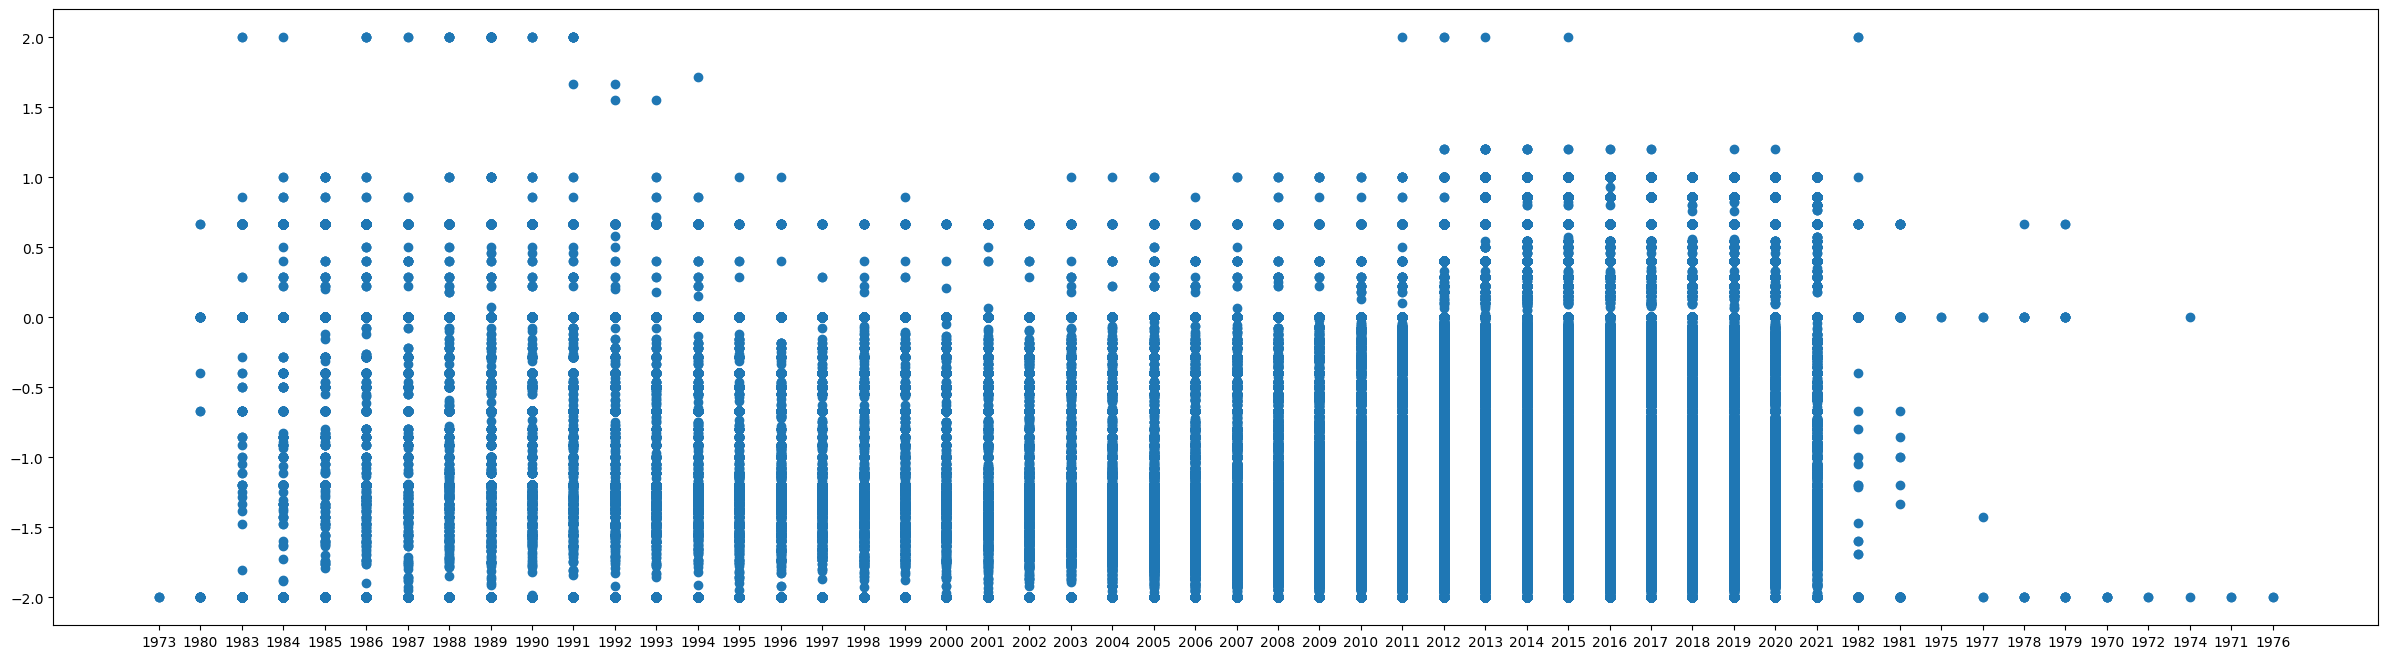

In [59]:
# how does it look across time? theres something wrong with this year variable
import matplotlib.pyplot as plt
plt.figure(figsize=(30,8))
plt.scatter(regression.year, regression.case_DELTA_cl_rel)


plt.show()

### Add the county stuff

In [60]:
# import county demographic proportions and representations
admissions = pd.read_csv('/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/admissions_analysis_table.csv')
zip_county_crosswalk = pd.read_excel('/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/ZIP_COUNTY.xlsx')

admissions.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
admissions.sample(5)
zip_county_crosswalk = zip_county_crosswalk[['zip', 'county', 'usps_zip_pref_city', 'usps_zip_pref_state']]
#zip_county_crosswalk.rename(columns={'zip':'def_zip_address'}, inplace=True)
zip_county_crosswalk = zip_county_crosswalk.loc[zip_county_crosswalk['usps_zip_pref_state']=='NC']
#zip_county_crosswalk['zip'] = zip_county_crosswalk['zip'].astype('int')
zip_county_crosswalk['zip'] = zip_county_crosswalk['zip'].astype('str')

admissions['county_fips_code'] = admissions['county_fips_code'].astype('int') 

# merge ZIP with crosswalk to FIPS
regression_fips = pd.merge(regression,zip_county_crosswalk, how='left', left_on='def_zip_address', right_on='zip', indicator=True, validate='m:m')
regression_fips.drop('_merge', axis=1, inplace=True)

# merge with admissions data from preet
regression_admissions = pd.merge(regression_fips,admissions, how='left', left_on='county', right_on='county_fips_code', indicator=True, validate='m:m')
regression_admissions._merge.value_counts()

regression_admissions.sample(3)
regression_admissions.to_csv('/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/30_gis/plea_deltas_admissions.csv')

regression_admissions.sample(3)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/clarissaache/Documents/Capstone/JUSTFAIR_capstone/admissions_analysis_table.csv'

In [ ]:
regression_admissions.sample(3)

,case_id,CL_Rank,case_DELTA_cl,case_DELTA_ms,case_DELTA_cl_perc,case_DELTA_ms_perc,case_DELTA_cl_rel,case_DELTA_ms_rel,key_county_num,key_year,race,sex,court_attorney_type,process_served,prior_record_points,plea_code,def_zip_address,year,zip,county,usps_zip_pref_city,usps_zip_pref_state,county_fips_code,black_count_sys,white_count_sys,hisp_count_sys,total_count_sys,black_perc_sys,white_perc_sys,hisp_perc_sys,COUNTY,total,black_pop,white_pop,hisp_pop,other_pop,total_perc,black_pop_perc,white_pop_perc,hisp_pop_perc,other_pop_perc,white_rate_of_case,black_rate_of_case,times_b_more_likely_to_be_involved_in_case,trial_metric,weighted_rep_difference_b_w,_merge
5648218,4202007701737,2.0,-2.0,-0.540863,-100.0,-100.0,-2.000000,-2.0,420,2007,White,Male,Public Defender ($ salaried),C,NaN,NaN,28334,2007,28334,37085.0,DUNN,NC,37085.0,141424.0,194738.0,51500.0,405538.0,34.873181,48.019668,12.699180,Harnett County,128753.0,27243.0,79933.0,16210.0,5367.0,100.0,21.159119,62.082437,12.589998,4.168447,2.436265,5.191205,2.130804,0.874657,0.874657,both
655971,902014702813,1.0,1.0,0.000000,100.0,0.0,0.666667,0.0,90,2014,White,Male,Waived Attorney,C,0.0,GU,28425,2014,28425,37141.0,BURGAW,NC,37141.0,64465.0,99577.0,14258.0,184573.0,34.926560,53.949928,7.724857,Pender County,57630.0,9028.0,42945.0,4057.0,1600.0,100.0,15.665452,74.518480,7.039736,2.776332,2.318710,7.140563,3.079541,1.505547,1.505547,both
1722846,1502013702747,2.0,0.0,0.000000,0.0,0.0,0.000000,0.0,150,2013,White,Male,Public Defender ($ salaried),C,0.0,GU,28560,2013,28560,37137.0,NEW BERN,NC,37137.0,21654.0,34026.0,2254.0,59835.0,36.189521,56.866383,3.767026,Pamlico County,12803.0,2375.0,9508.0,456.0,464.0,100.0,18.550340,74.263844,3.561665,3.624151,3.578671,9.117474,2.547726,1.185147,1.185147,both


In [ ]:
regression = regression_admissions[[
            "case_id",
            "CL_Rank",
            "case_DELTA_cl",
            "case_DELTA_ms",
            "case_DELTA_cl_perc",
            "case_DELTA_ms_perc",
            "case_DELTA_cl_rel",
            "case_DELTA_ms_rel",
            "key_county_num",
            "key_year",
            "race",
            "sex",
            #"charg_type",
            "court_attorney_type",
            "process_served",
            "prior_record_points",
            "plea_code",
            'def_zip_address',
            'usps_zip_pref_city',
            'year',
            'COUNTY',
            'total',
]].sort_values(['case_id','total'], ascending=False).drop_duplicates(subset = 'case_id', keep='first')
print(regression.shape)

(8067356, 21)


In [ ]:
regression.sample(4)

,case_id,CL_Rank,case_DELTA_cl,case_DELTA_ms,case_DELTA_cl_perc,case_DELTA_ms_perc,case_DELTA_cl_rel,case_DELTA_ms_rel,key_county_num,key_year,race,sex,court_attorney_type,process_served,prior_record_points,plea_code,def_zip_address,usps_zip_pref_city,year,COUNTY,total
4887683,4002012074136,15.0,-12.0,-14.897854,-80.0,-96.352954,-1.333333,-1.859251,400,2012,Black,Male,Waived Attorney,W,5.0,GU,27407,GREENSBORO,2012,Guilford County,517197.0
4089968,3302015732327,1.0,-1.0,-0.183528,-100.0,-100.000000,-2.000000,-2.000000,330,2015,White,Female,Waived Attorney,C,NaN,NaN,27052,WALNUT COVE,2015,Forsyth County,368362.0
6054125,4402017704537,2.0,2.0,0.000000,100.0,0.000000,0.666667,0.000000,440,2017,Hispanic,Male,Public Defender ($ salaried),C,0.0,GU,28731,FLAT ROCK,2017,Henderson County,112156.0
10416617,7702012709565,2.0,-2.0,-0.715806,-100.0,-100.000000,-2.000000,-2.000000,770,2012,Hispanic,Male,Public Defender ($ salaried),C,NaN,NaN,28376,RAEFORD,2012,Hoke County,52571.0


District Court Attorney Type Code<br>
* A - Appointed
* P - Public Defender
* R - Privately Retained or Self
* W - Waived

## Regression # 1: **Capstone Presentation**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          case_DELTA_cl   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                 1.163e+04
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:31:54   Log-Likelihood:            -4.7150e+06
No. Observations:             1518819   AIC:                         9.430e+06
Df Residuals:                 1518808   BIC:                         9.430e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -2.5677      0.066    -39.113      0.000      -2.696      -2.439
race[T.Black]                                                 -0.3827      0.065     -5.908      0.000      -0.510      -0.256
race[T.Hispanic]                                               0.4056      0.065      6.208      0.000       0.278       0.534
race[T.Other]                                                  0.0250      0.068      0.367      0.713      -0.109       0.159
race[T.White]                                                 -0.3244      0.065     -5.020      0.000      -0.451      -0.198
sex[T.Male]                                                   -0.0993      0.010    -10.242      0.000      -0.118      -0.080
sex[T.Other]                                                  -1.4195      0.153     -9.296      0.000      -1.719      -1.120
court_attorney_type[T.Privately Retained Attorney or Self]     0.2733      0.018     15.307      0.000       0.238       0.308
court_attorney_type[T.Public Defender ($ salaried)]            2.6524      0.013    201.967      0.000       2.627       2.678
court_attorney_type[T.Waived Attorney]                         2.0824      0.014    152.248      0.000       2.056       2.109
prior_record_points                                           -0.2428      0.002   -127.214      0.000      -0.247      -0.239
==============================================================================
Omnibus:                  2884736.811   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      26274292119.826
Skew:                         -14.046   Prob(JB):                         0.00
Kurtosis:                     646.732   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

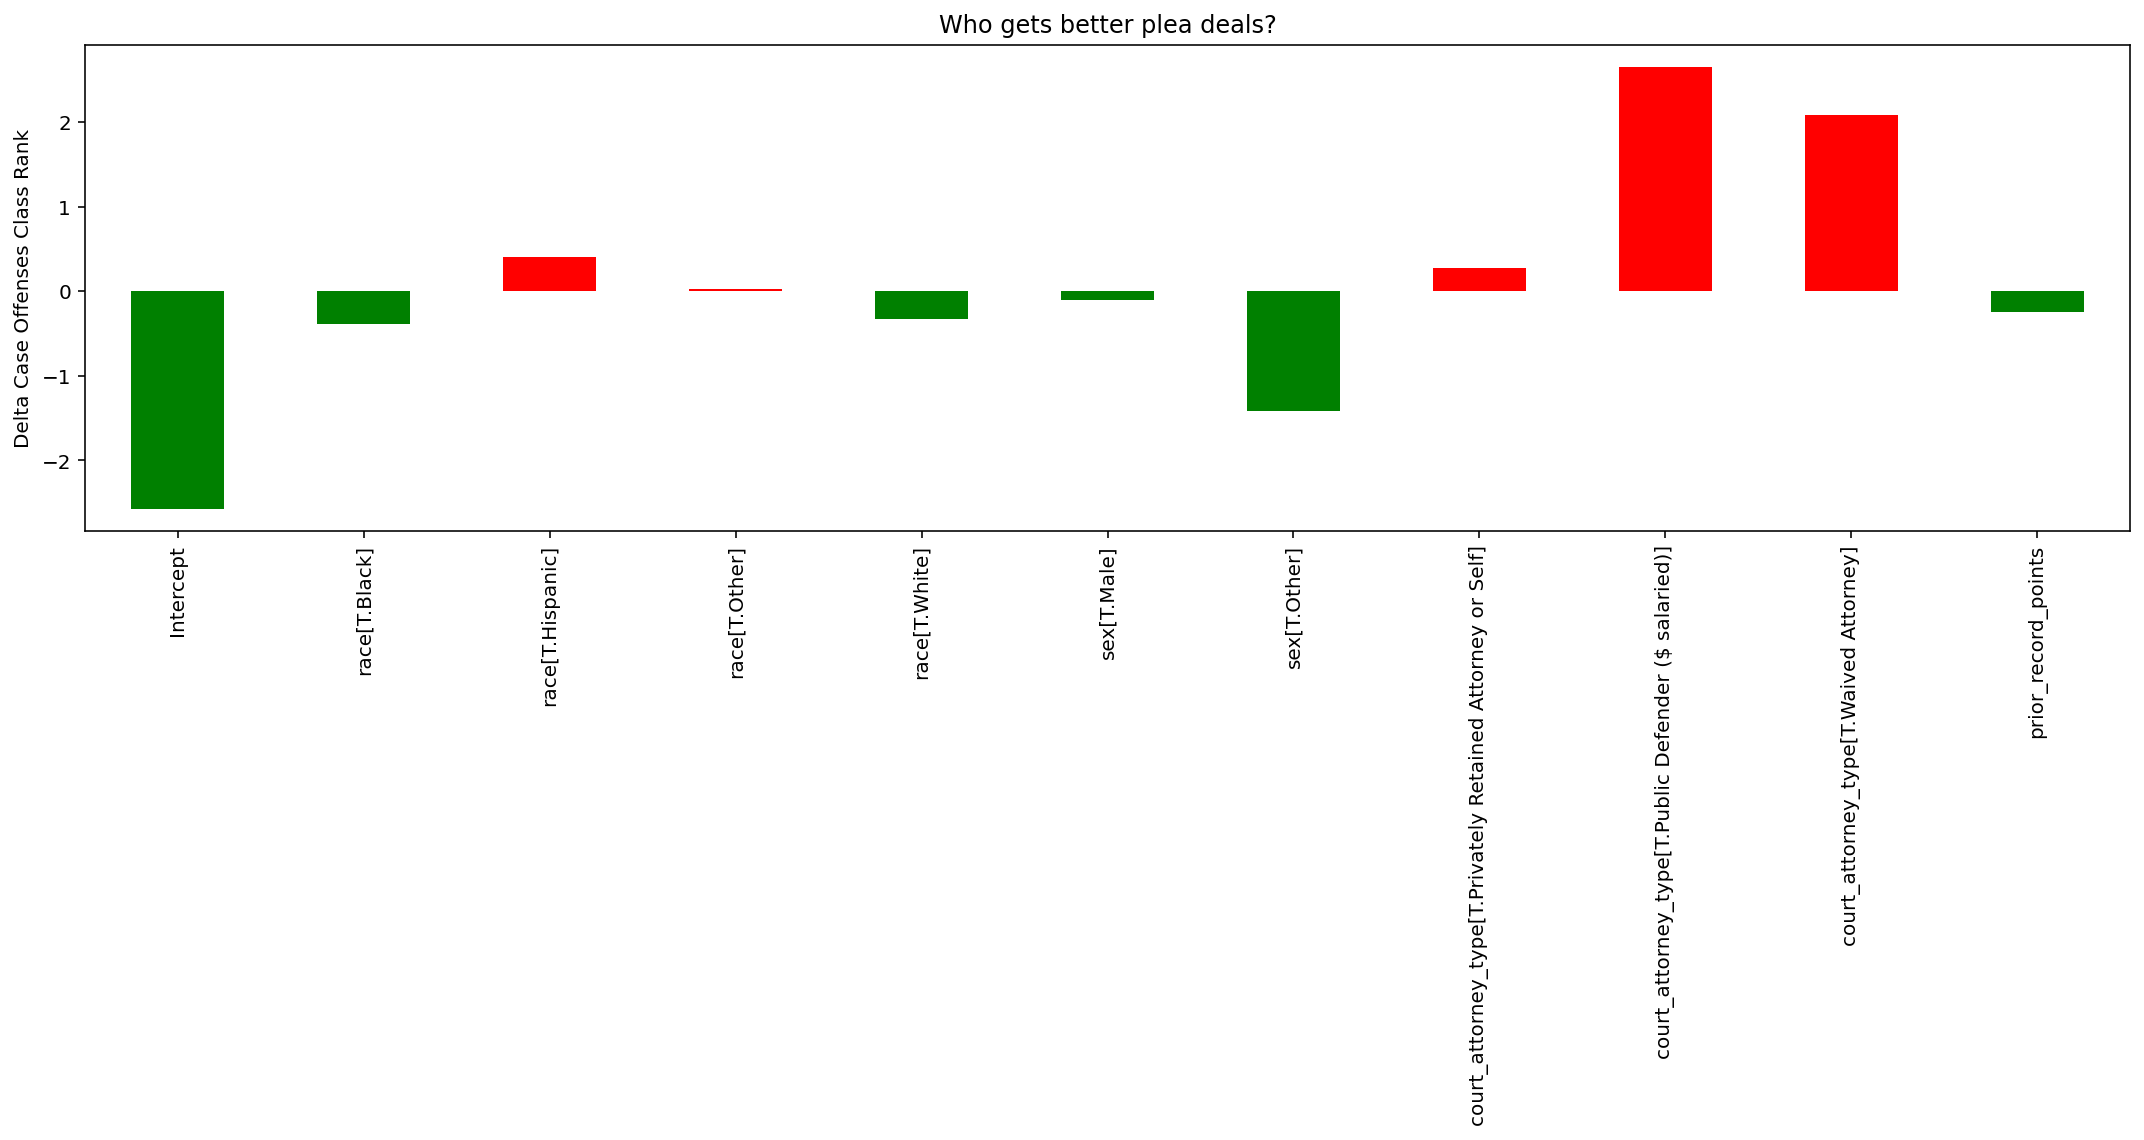

In [ ]:
import statsmodels.formula.api as smf
######################## THIS IS WHAT WENT IN THE PRESENTATION #############################

# Using the Class Rank severity scale
m_RANK = smf.ols("case_DELTA_cl ~ race + sex + prior_record_points + court_attorney_type", regression).fit() 
colors = ['r' if m > 0 else 'g' for m in m_RANK.params]

# plot effects
m_RANK.params.plot(kind='bar', title= "Who gets better plea deals?", figsize=(15,8),color=colors,legend=False, ylabel='Delta Case Offenses Class Rank')  
plt.tight_layout()
plt.savefig('Who_gets_better_deals.png', transparent=True)
m_RANK.summary()


## Regression # 2: **Controlling for the process served, which how defendants learn their charges**
This could be a source of variation, so should I control for it? (e.g. black people getting targeted arrests)
lets see...

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          case_DELTA_cl   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                 1.190e+04
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:33:06   Log-Likelihood:            -4.6761e+06
No. Observations:             1518819   AIC:                         9.352e+06
Df Residuals:                 1518801   BIC:                         9.352e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -14.2434      0.122   -116.427      0.000     -14.483     -14.004
race[T.Black]                                                 -0.2949      0.063     -4.670      0.000      -0.419      -0.171
race[T.Hispanic]                                               0.2589      0.064      4.065      0.000       0.134       0.384
race[T.Other]                                                  0.1752      0.066      2.638      0.008       0.045       0.305
race[T.White]                                                 -0.1616      0.063     -2.565      0.010      -0.285      -0.038
sex[T.Male]                                                   -0.0206      0.009     -2.173      0.030      -0.039      -0.002
sex[T.Other]                                                  -0.1128      0.149     -0.755      0.450      -0.405       0.180
court_attorney_type[T.Privately Retained Attorney or Self]     0.1956      0.017     11.214      0.000       0.161       0.230
court_attorney_type[T.Public Defender ($ salaried)]            1.5447      0.014    113.129      0.000       1.518       1.571
court_attorney_type[T.Waived Attorney]                         1.3479      0.014     98.595      0.000       1.321       1.375
process_served[T.C]                                           12.9096      0.105    123.262      0.000      12.704      13.115
process_served[T.I]                                            2.0659      0.497      4.155      0.000       1.091       3.040
process_served[T.M]                                           11.4701      0.105    109.428      0.000      11.265      11.676
process_served[T.O]                                            5.9514      0.113     52.703      0.000       5.730       6.173
process_served[T.S]                                           11.0783      0.108    102.993      0.000      10.868      11.289
process_served[T.W]                                            9.9055      0.105     94.496      0.000       9.700      10.111
process_served[T.X]                                           11.9747      0.120     99.870      0.000      11.740      12.210
prior_record_points                                           -0.1472      0.002    -77.449      0.000      -0.151      -0.144
==============================================================================
Omnibus:                  2906750.755   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      29877989302.760
Skew:                         -14.250   Prob(JB):                         0.00
Kurtosis:                     689.522   Cond. No.                         351.
=====================

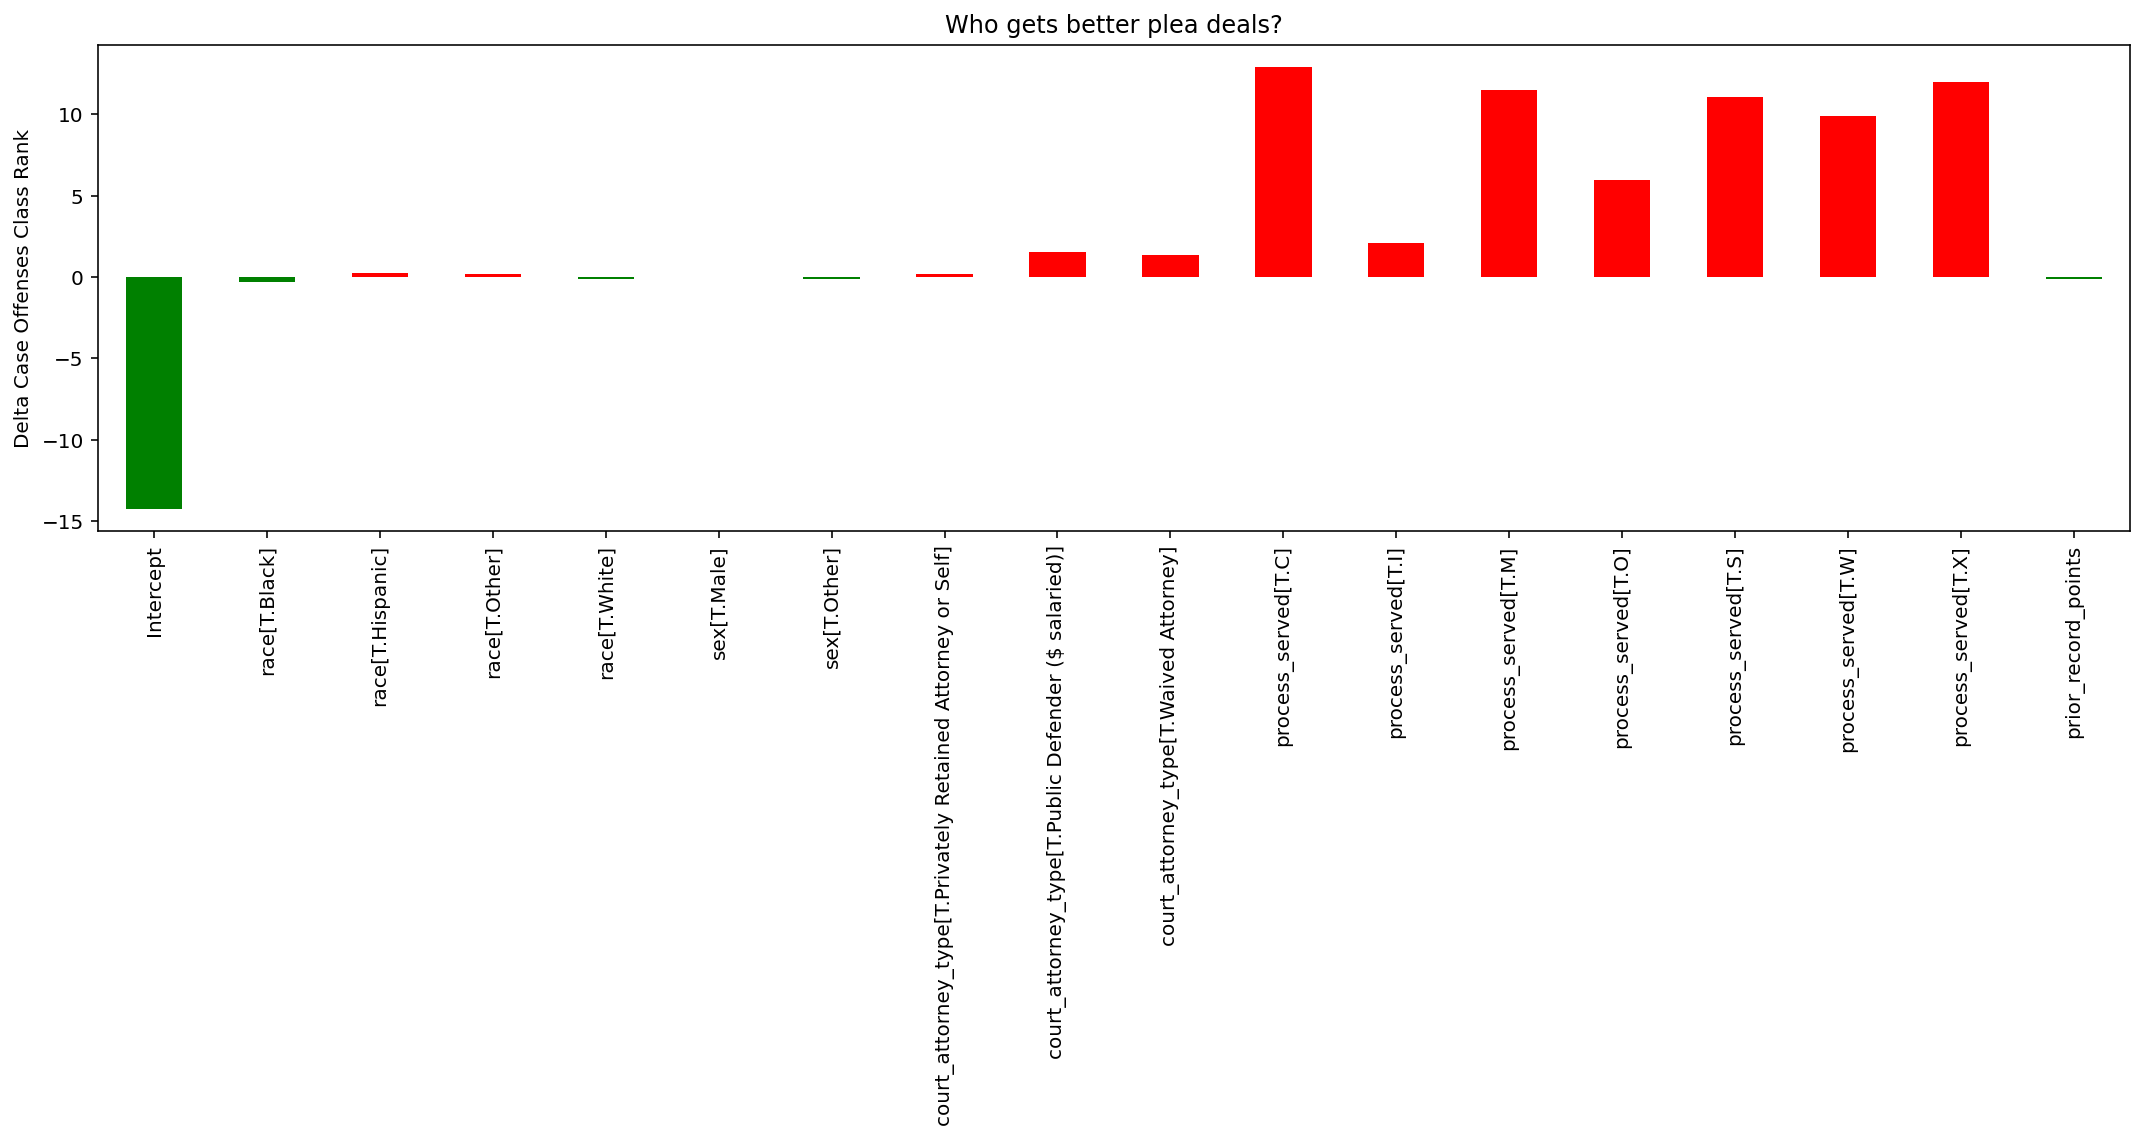

In [ ]:
# ADDING PROCESS SERVED
m_RANK = smf.ols("case_DELTA_cl ~ race + sex + prior_record_points + court_attorney_type + process_served", regression).fit() # controlling for initial charge gives me the plea bargain 
colors = ['r' if m > 0 else 'g' for m in m_RANK.params]

# plot effects
m_RANK.params.plot(kind='bar', title= "Who gets better plea deals?", figsize=(15,8),color=colors,legend=False, ylabel='Delta Case Offenses Class Rank')  
plt.tight_layout()
plt.savefig('Who_gets_better_deals.png', transparent=True)
m_RANK.summary()

## Regression # 3: **Using relative delta instead of absolute**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      case_DELTA_cl_rel   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                 3.217e+04
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:34:05   Log-Likelihood:            -1.4077e+06
No. Observations:             1518819   AIC:                         2.815e+06
Df Residuals:                 1518808   BIC:                         2.816e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -0.3270      0.007    -43.959      0.000      -0.342      -0.312
race[T.Black]                                                 -0.0985      0.007    -13.413      0.000      -0.113      -0.084
race[T.Hispanic]                                               0.1592      0.007     21.508      0.000       0.145       0.174
race[T.Other]                                                 -0.0541      0.008     -7.008      0.000      -0.069      -0.039
race[T.White]                                                 -0.0991      0.007    -13.532      0.000      -0.113      -0.085
sex[T.Male]                                                   -0.0146      0.001    -13.261      0.000      -0.017      -0.012
sex[T.Other]                                                  -0.5853      0.017    -33.824      0.000      -0.619      -0.551
court_attorney_type[T.Privately Retained Attorney or Self]     0.0103      0.002      5.088      0.000       0.006       0.014
court_attorney_type[T.Public Defender ($ salaried)]            0.4762      0.001    319.954      0.000       0.473       0.479
court_attorney_type[T.Waived Attorney]                         0.1884      0.002    121.526      0.000       0.185       0.191
prior_record_points                                           -0.0311      0.000   -143.810      0.000      -0.032      -0.031
==============================================================================
Omnibus:                   242628.125   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           391017.828
Skew:                          -1.101   Prob(JB):                         0.00
Kurtosis:                       4.155   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

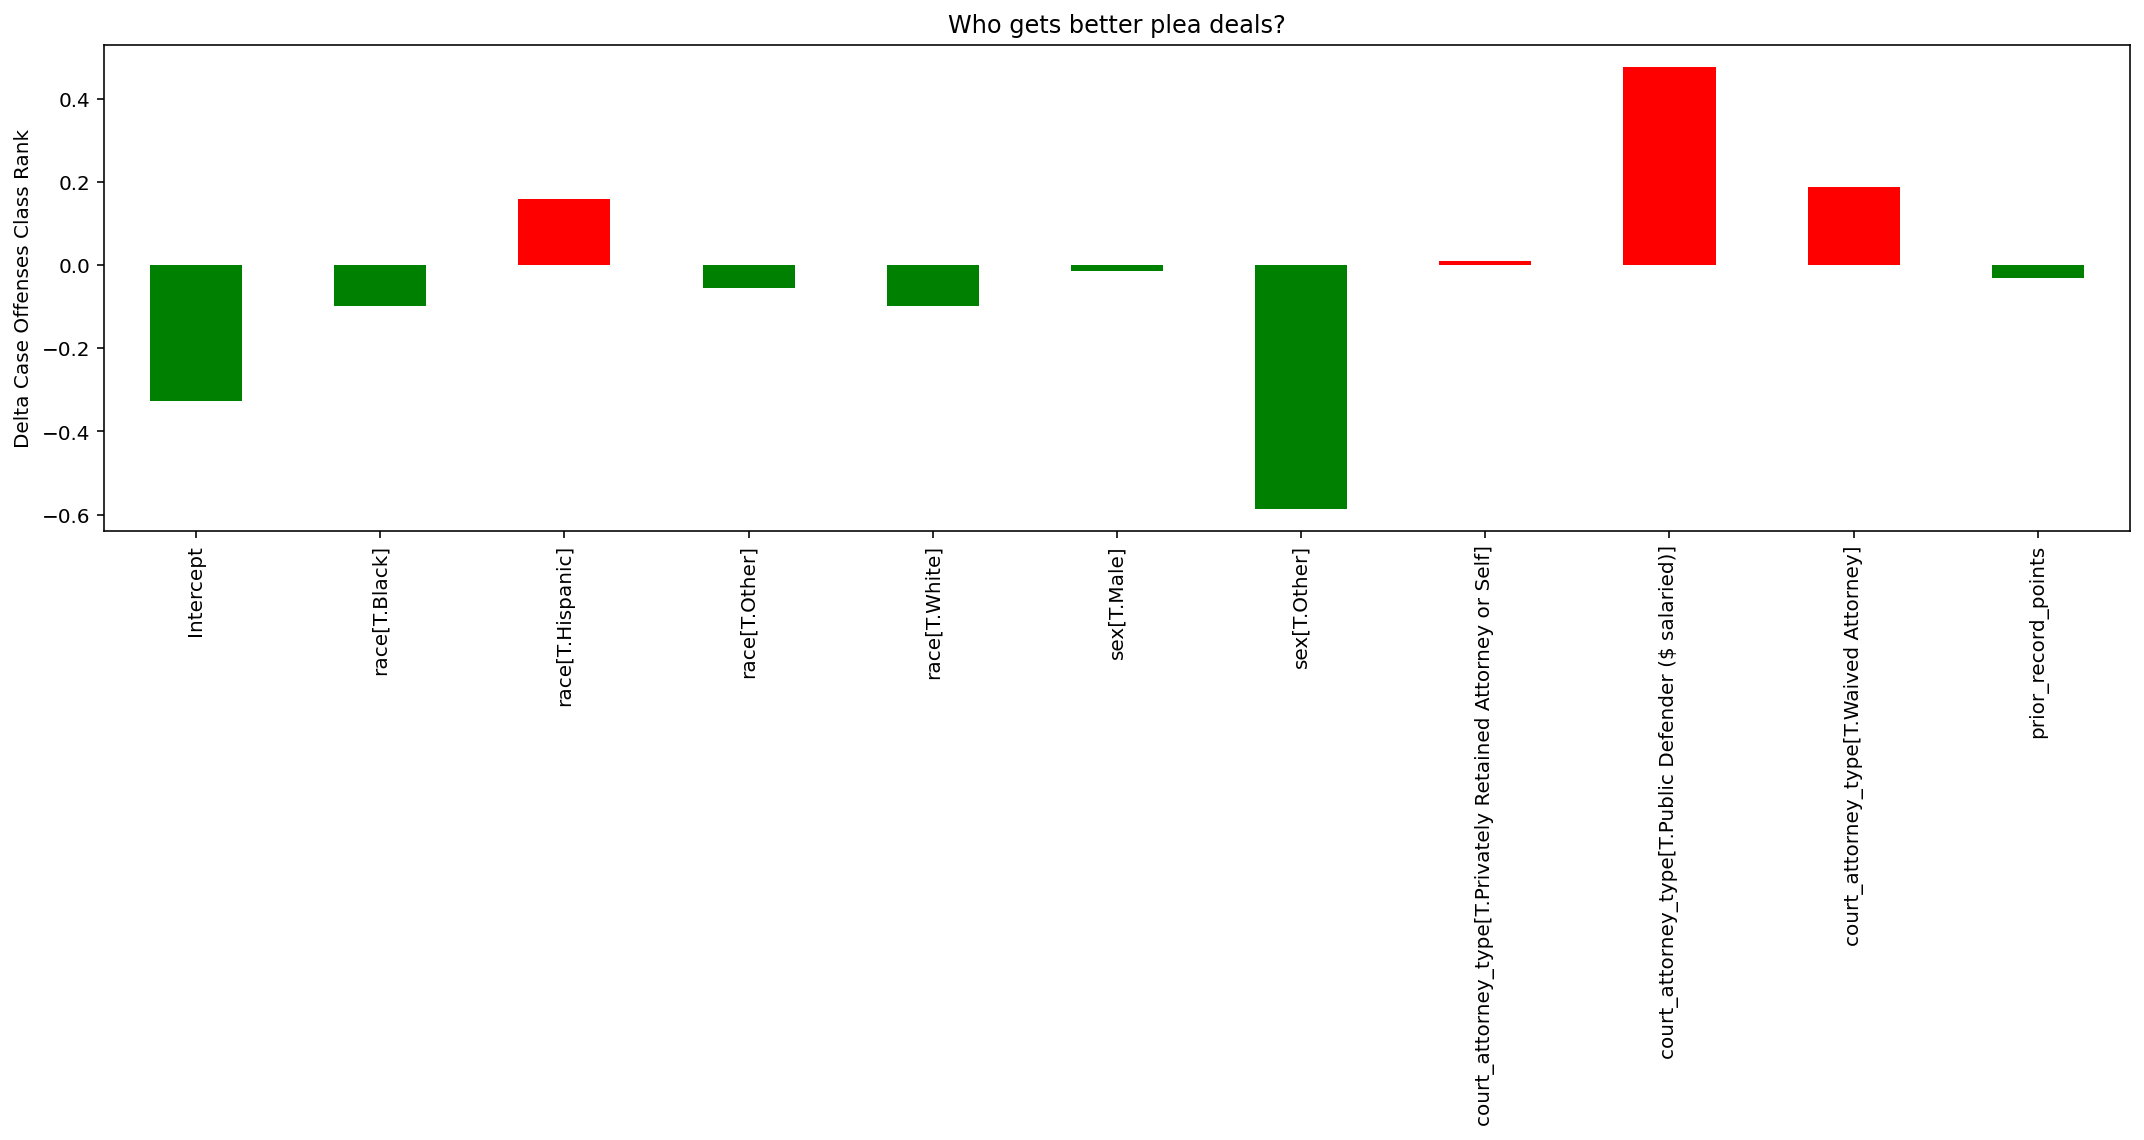

In [ ]:
# NOW, IF I DO THE RELATIVE CHANGE as my response variable

# Using the Class Rank severity scale
m_RANK = smf.ols("case_DELTA_cl_rel ~ race + sex + prior_record_points + court_attorney_type", regression).fit() # controlling for initial charge gives me the plea bargain 
colors = ['r' if m > 0 else 'g' for m in m_RANK.params]

# plot effects
m_RANK.params.plot(kind='bar', title= "Who gets better plea deals?", figsize=(15,8),color=colors,legend=False, ylabel='Delta Case Offenses Class Rank')  
plt.tight_layout()
plt.savefig('Who_gets_better_deals.png', transparent=True)
m_RANK.summary()
#
#
# ok, when I controlled for process served, it makes black people get better deals than whites. 
# Process served does explain a difference between whites and blacks. 
# It furthers my belief about how white people are getting into the system is different than blacks

## Regression # 4: **Using relative delta instead of absolute**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      case_DELTA_ms_rel   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                 2.004e+04
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:35:07   Log-Likelihood:            -1.3132e+06
No. Observations:             1518819   AIC:                         2.626e+06
Df Residuals:                 1518808   BIC:                         2.627e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -0.5405      0.007    -77.318      0.000      -0.554      -0.527
race[T.Black]                                                 -0.1331      0.007    -19.294      0.000      -0.147      -0.120
race[T.Hispanic]                                               0.0536      0.007      7.710      0.000       0.040       0.067
race[T.Other]                                                 -0.0061      0.007     -0.846      0.397      -0.020       0.008
race[T.White]                                                 -0.0693      0.007    -10.068      0.000      -0.083      -0.056
sex[T.Male]                                                   -0.0029      0.001     -2.811      0.005      -0.005      -0.001
sex[T.Other]                                                  -0.1766      0.016    -10.862      0.000      -0.209      -0.145
court_attorney_type[T.Privately Retained Attorney or Self]     0.0017      0.002      0.885      0.376      -0.002       0.005
court_attorney_type[T.Public Defender ($ salaried)]            0.3998      0.001    285.894      0.000       0.397       0.403
court_attorney_type[T.Waived Attorney]                         0.2629      0.001    180.530      0.000       0.260       0.266
prior_record_points                                           -0.0165      0.000    -81.003      0.000      -0.017      -0.016
==============================================================================
Omnibus:                   158647.957   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           214667.776
Skew:                          -0.920   Prob(JB):                         0.00
Kurtosis:                       3.098   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

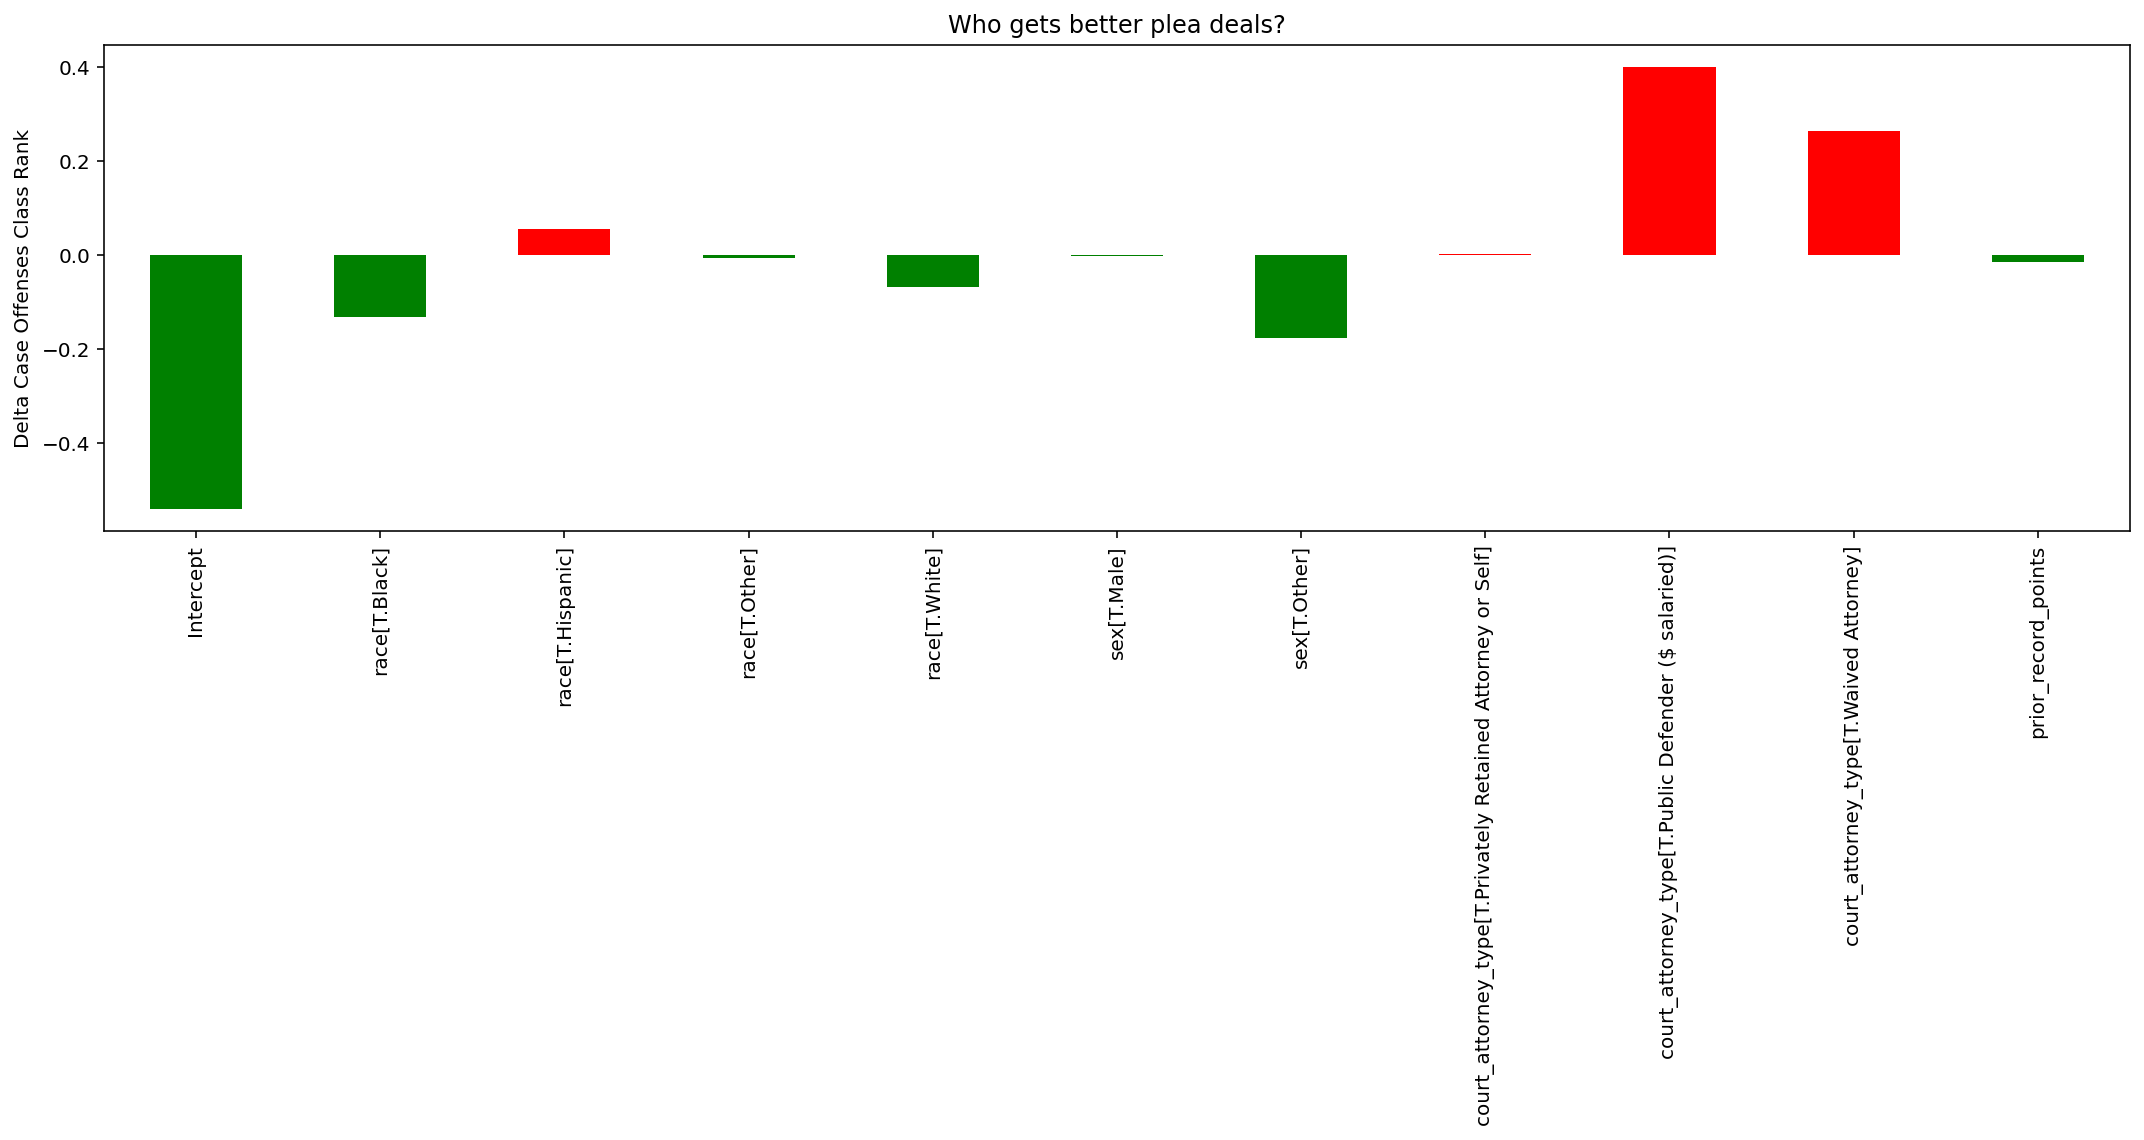

In [ ]:
# AGAIN, THE RELATIVE CHANGE as my response variable BUT with the min sentence severity scores

# Using the MIN SENTence Rank severity scale
m_RANK = smf.ols("case_DELTA_ms_rel ~ race + sex + prior_record_points + court_attorney_type", regression).fit() # controlling for initial charge gives me the plea bargain 
colors = ['r' if m > 0 else 'g' for m in m_RANK.params]

# plot effects
m_RANK.params.plot(kind='bar', title= "Who gets better plea deals?", figsize=(15,8),color=colors,legend=False, ylabel='Delta Case Offenses Class Rank')  
plt.tight_layout()
plt.savefig('Who_gets_better_deals.png', transparent=True)
m_RANK.summary()

## Regression # 5: **Adding COUNTY**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      case_DELTA_cl_rel   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     3198.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:58:18   Log-Likelihood:            -1.3967e+06
No. Observations:             1518819   AIC:                         2.794e+06
Df Residuals:                 1518709   BIC:                         2.795e+06
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -0.2907      0.008    -35.770      0.000      -0.307      -0.275
race[T.Black]                                                 -0.0689      0.007     -9.436      0.000      -0.083      -0.055
race[T.Hispanic]                                               0.1876      0.007     25.475      0.000       0.173       0.202
race[T.Other]                                                 -0.0283      0.008     -3.655      0.000      -0.043      -0.013
race[T.White]                                                 -0.0639      0.007     -8.768      0.000      -0.078      -0.050
sex[T.Male]                                                   -0.0130      0.001    -11.875      0.000      -0.015      -0.011
sex[T.Other]                                                  -0.5557      0.017    -32.309      0.000      -0.589      -0.522
court_attorney_type[T.Privately Retained Attorney or Self]    -0.0224      0.002    -10.221      0.000      -0.027      -0.018
court_attorney_type[T.Public Defender ($ salaried)]            0.4635      0.002    304.634      0.000       0.460       0.466
court_attorney_type[T.Waived Attorney]                         0.1763      0.002    111.145      0.000       0.173       0.179
key_county_num[T.10]                                          -0.0503      0.009     -5.645      0.000      -0.068      -0.033
key_county_num[T.100]                                          0.0450      0.005      9.240      0.000       0.035       0.055
key_county_num[T.110]                                         -0.0277      0.006     -4.583      0.000      -0.040      -0.016
key_county_num[T.120]                                         -0.0153      0.004     -3.506      0.000      -0.024      -0.007
key_county_num[T.130]                                         -0.1296      0.006    -21.382      0.000      -0.141      -0.118
key_county_num[T.140]                                          0.0695      0.015      4.542      0.000       0.040       0.099
key_county_num[T.150]                                         -0.0775      0.006    -12.353      0.000      -0.090      -0.065
key_county_num[T.160]                                         -0.1182      0.012    -10.218      0.000      -0.141      -0.096
key_county_num[T.170]                                         -0.0655      0.005    -13.439      0.000      -0.075      -0.056
key_county_num[T.180]                                         -0.0542      0.007     -7.967      0.000      -0.068      -0.041
key_county_num[T.190]                                         -0.0917      0.012     -7.909      0.000      -0.114      -0.069
key_county_num[T.20]               

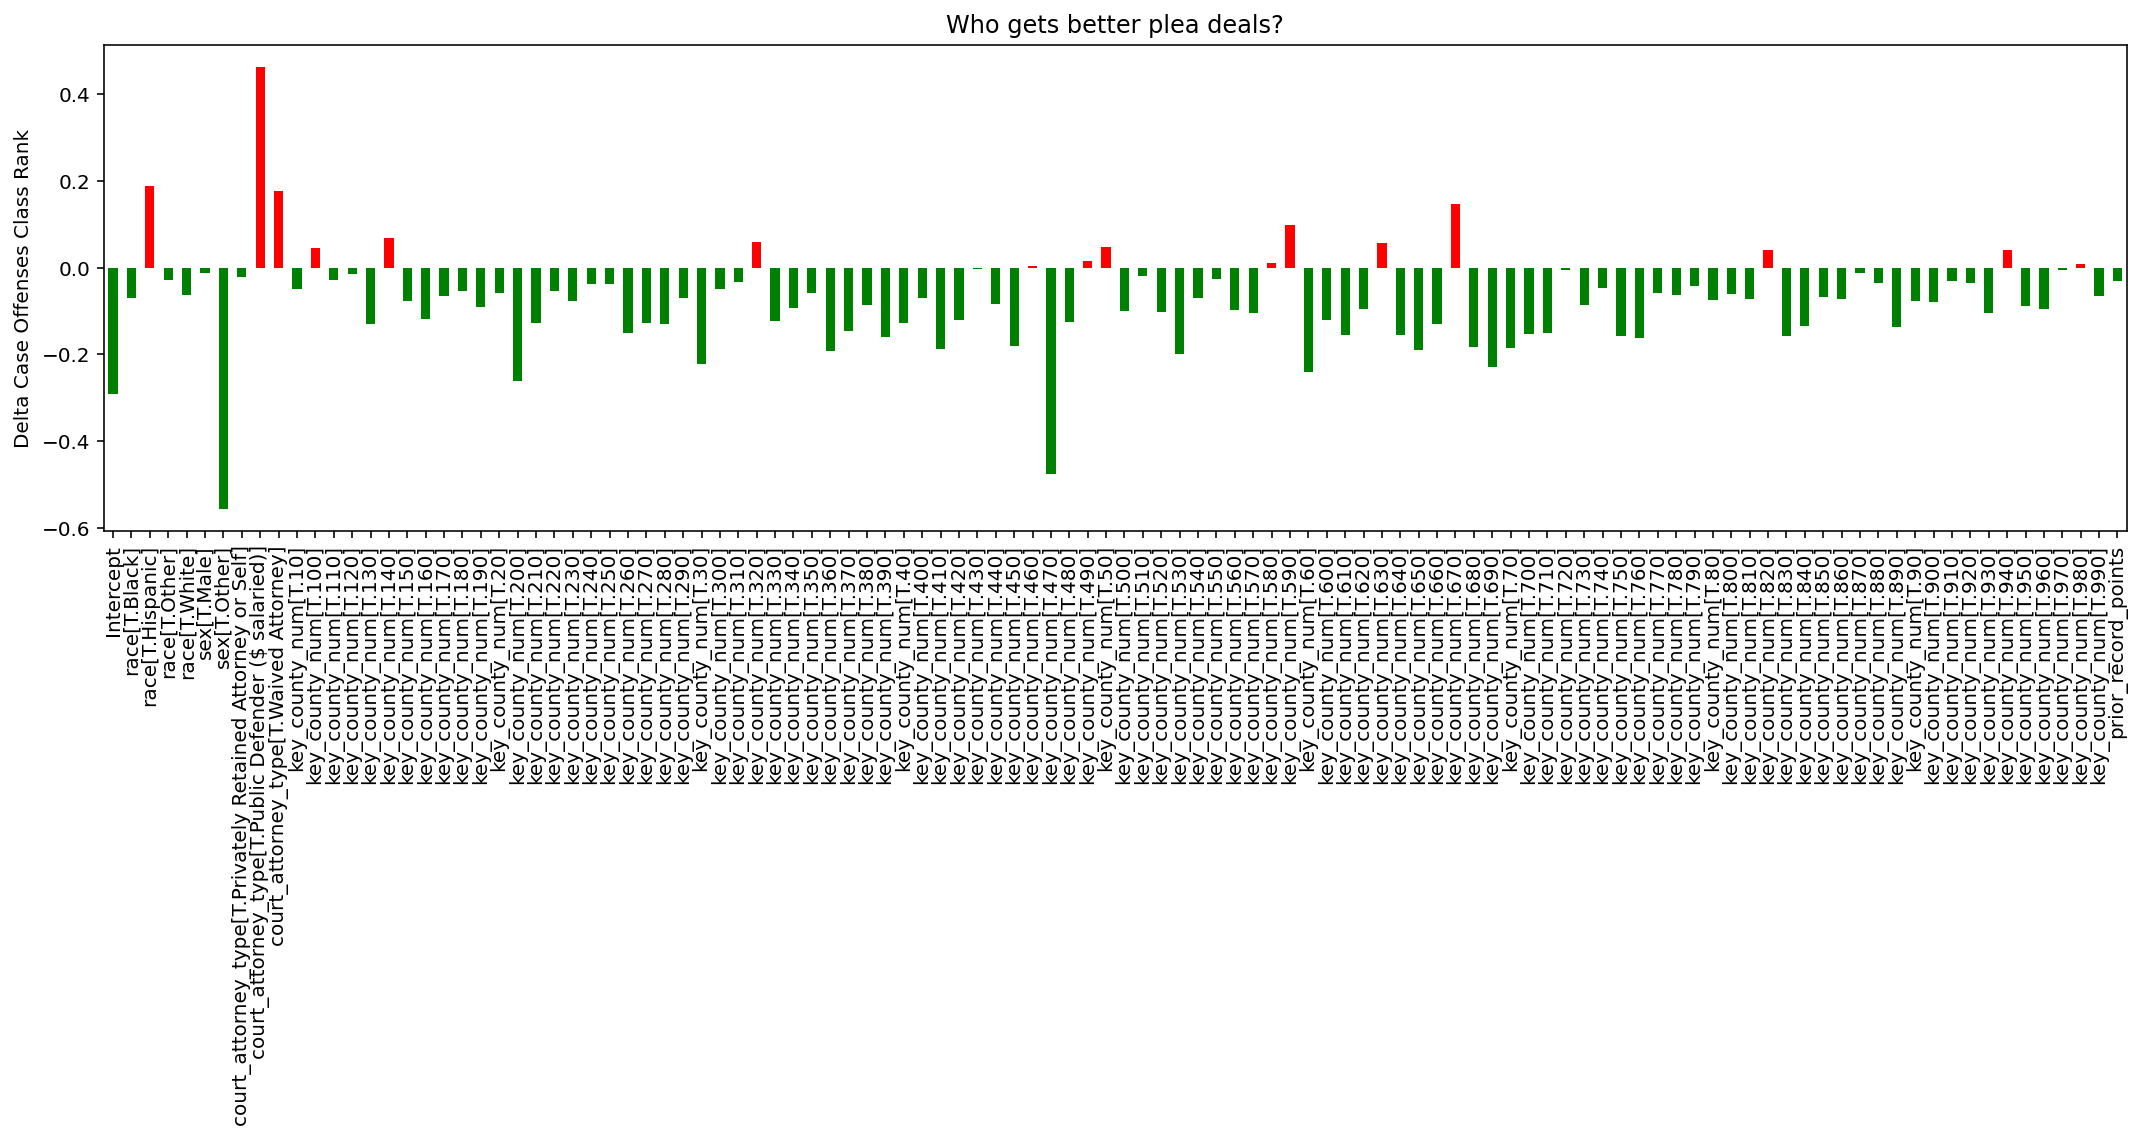

In [ ]:
# ADDING COUNTY
m_RANK = smf.ols("case_DELTA_cl_rel ~ race + sex + prior_record_points + court_attorney_type + key_county_num", regression).fit() # controlling for initial charge gives me the plea bargain 
colors = ['r' if m > 0 else 'g' for m in m_RANK.params]

# plot effects
m_RANK.params.plot(kind='bar', title= "Who gets better plea deals?", figsize=(15,8),color=colors,legend=False, ylabel='Delta Case Offenses Class Rank')  
plt.tight_layout()
plt.savefig('Who_gets_better_deals.png', transparent=True)
m_RANK.summary()

In [ ]:
pd.crosstab(regression.race, regression.process_served)

process_served,B,C,I,M,O,S,W,X
race,,,,,,,,
Asian,6,35797,0,6945,272,557,4138,93
Black,1787,1602639,479,655815,36512,94095,739427,12495
Hispanic,141,534851,44,80600,1138,4612,40606,1408
Other,99,185902,46,42617,6622,19210,59685,623
White,3615,2153509,732,748038,55667,122489,803232,10813


In [ ]:
regression[['race', 'case_DELTA_ms_rel']].groupby(by='race').mean()

,case_DELTA_ms_rel
race,
Asian,-0.717344
Black,-1.285000
Hispanic,-0.810801
Other,-1.027934
White,-1.129005


In [ ]:
regression.race.value_counts(normalize=True)*100

White       48.319363
Black       38.962567
Hispanic     8.223264
Other        3.902195
Asian        0.592611
Name: race, dtype: float64

In [ ]:
regression[['race', 'prior_record_points']].groupby(by='race').mean().sort_values('prior_record_points').reset_index()

,race,prior_record_points
0,Hispanic,0.263521
1,Asian,0.448745
2,Other,0.875962
3,White,1.505137
4,Black,1.785467


In [ ]:
round(pd.crosstab(regression.race, regression.court_attorney_type, normalize='index')*100,2)

court_attorney_type,Appointed ($ hourly),Privately Retained Attorney or Self,Public Defender ($ salaried),Waived Attorney
race,,,,
Asian,7.84,7.31,67.83,17.03
Black,24.62,18.87,32.42,24.09
Hispanic,7.06,5.21,73.36,14.37
Other,19.18,10.80,49.77,20.25
White,25.33,10.50,45.32,18.85


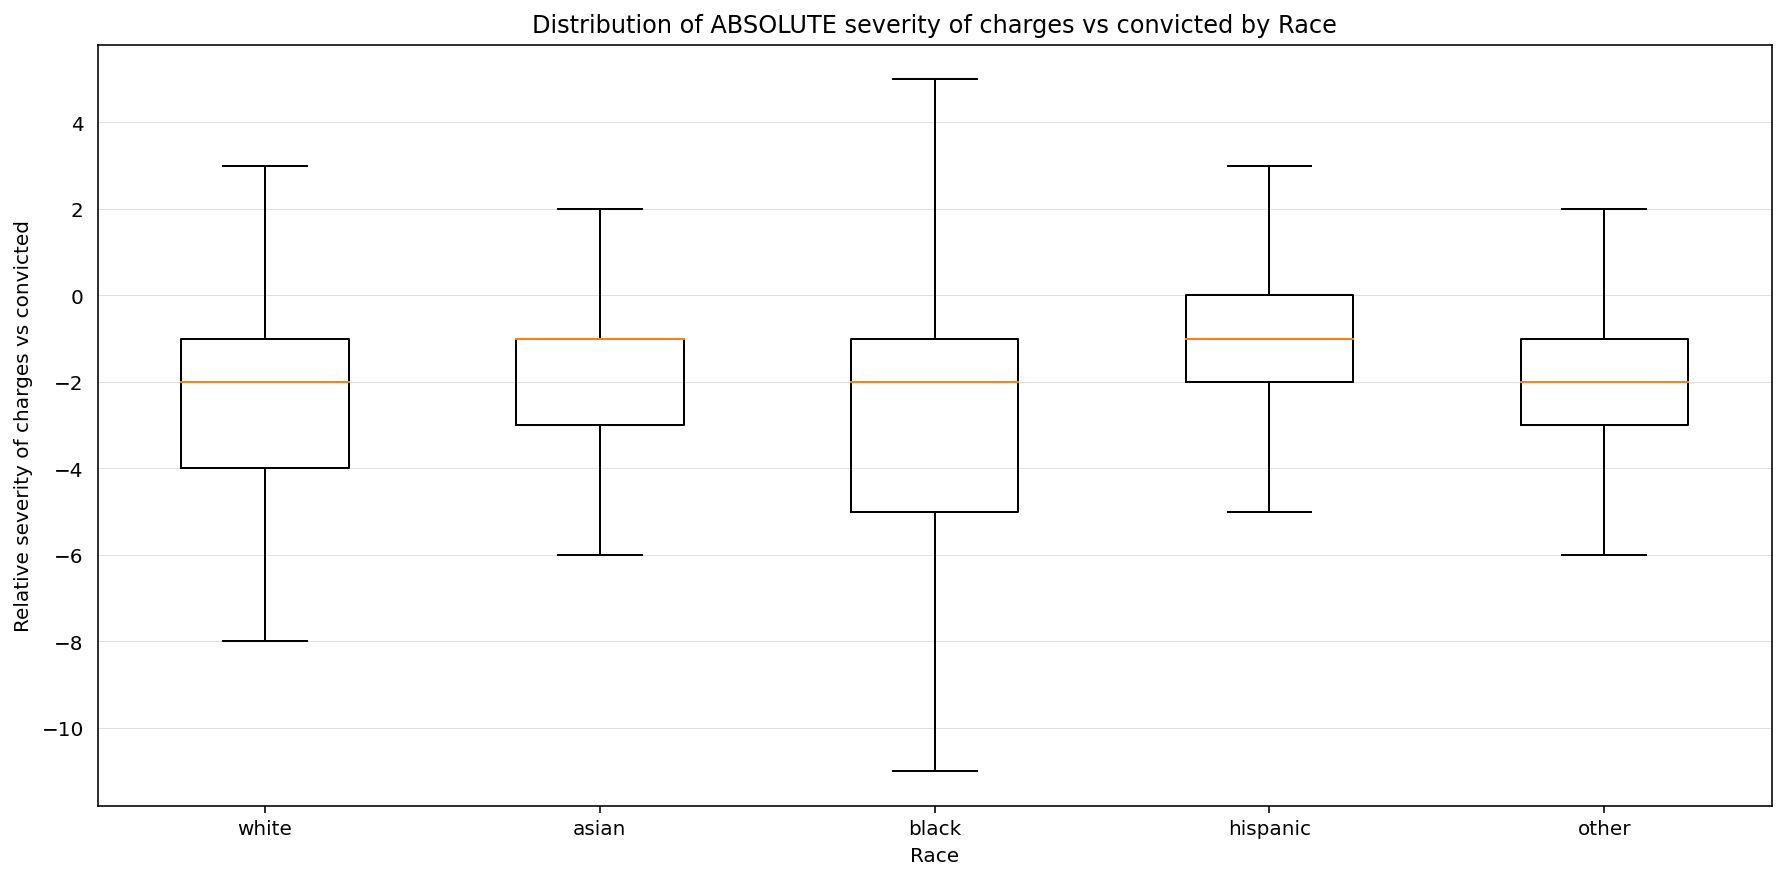

In [ ]:
# Boxplots

white = regression[regression["race"] == "White"]['case_DELTA_cl']
black = regression[regression["race"] == "Black"]['case_DELTA_cl']
asian = regression[regression["race"] == "Asian"]['case_DELTA_cl']
hispanic = regression[regression["race"] == "Hispanic"]['case_DELTA_cl']
other = regression[regression["race"] == "Other"]['case_DELTA_cl']

# Visualize petal length distribution for all species
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of ABSOLUTE severity of charges vs convicted by Race")
plt.xlabel("Race")
plt.ylabel("Relative severity of charges vs convicted")
# Set names as labels for the boxplot
dataset = [
    white,
    asian,
    black,
    hispanic,
    other,
]
ax.boxplot(
    dataset,
    labels=[
        "white",
        "asian",
        "black",
        "hispanic",
        "other",
    ],
    showfliers=False,
)
plt.show()

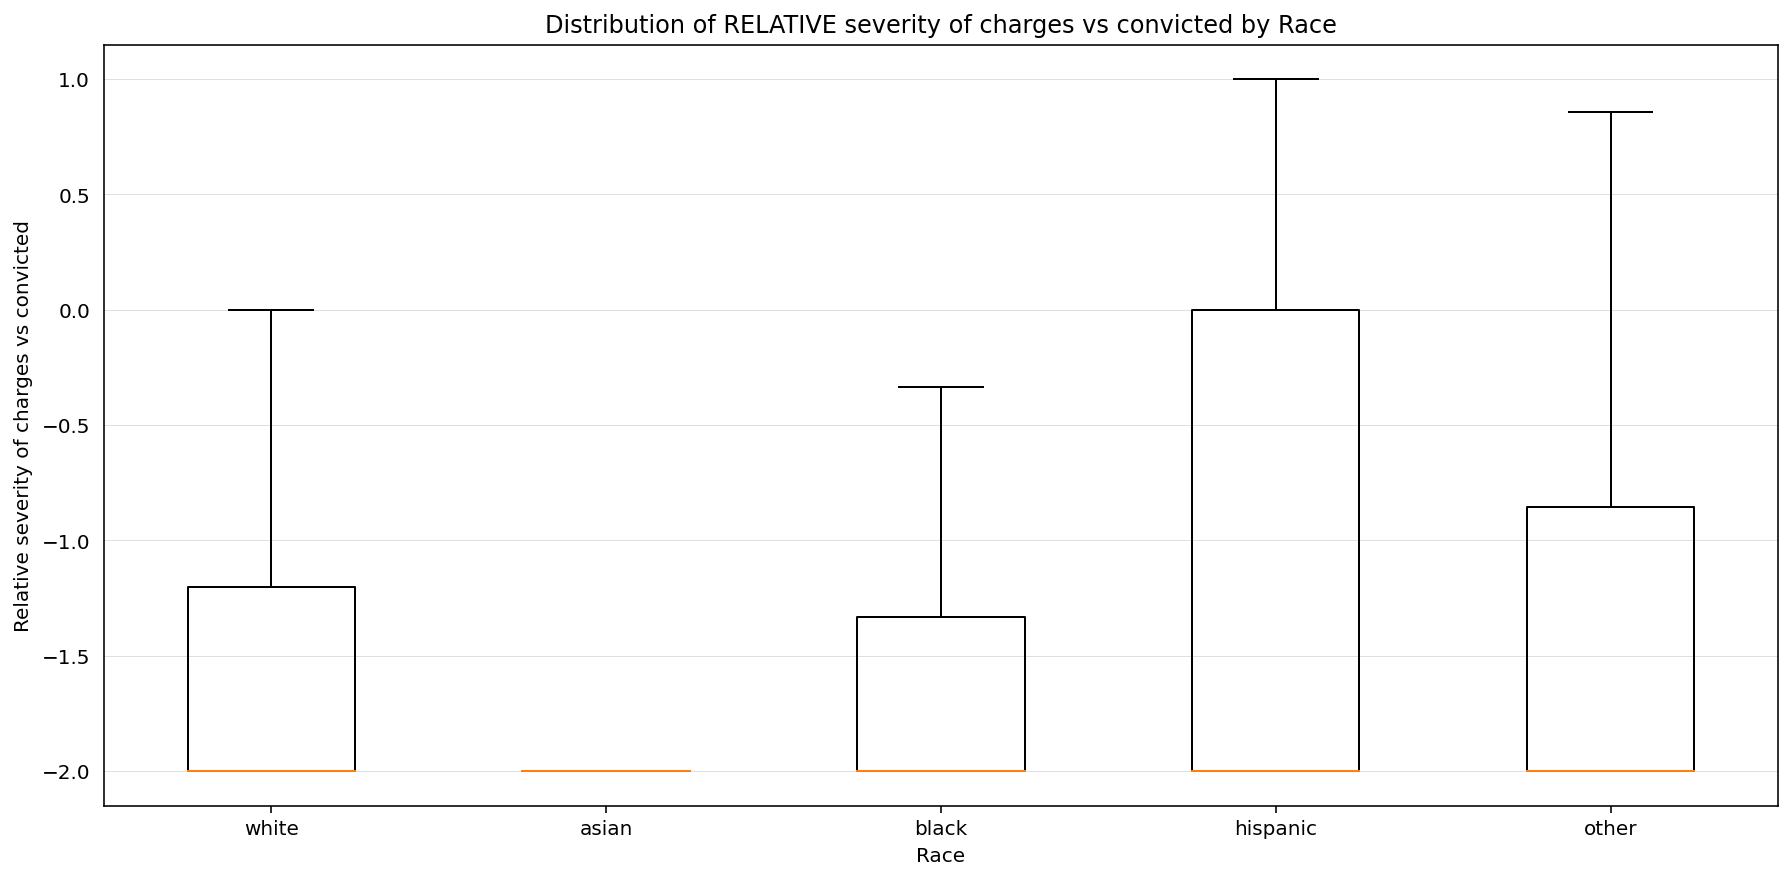

In [ ]:
# Boxplots

white = regression[regression["race"] == "White"]['case_DELTA_cl_rel']
black = regression[regression["race"] == "Black"]['case_DELTA_cl_rel']
asian = regression[regression["race"] == "Asian"]['case_DELTA_cl_rel']
hispanic = regression[regression["race"] == "Hispanic"]['case_DELTA_cl_rel']
other = regression[regression["race"] == "Other"]['case_DELTA_cl_rel']

# Visualize petal length distribution for all species
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of RELATIVE severity of charges vs convicted by Race")
plt.xlabel("Race")
plt.ylabel("Relative severity of charges vs convicted")
# Set names as labels for the boxplot
dataset = [
    white,
    asian,
    black,
    hispanic,
    other,
]
ax.boxplot(
    dataset,
    labels=[
        "white",
        "asian",
        "black",
        "hispanic",
        "other",
    ],
    showfliers=False,
)
plt.show()

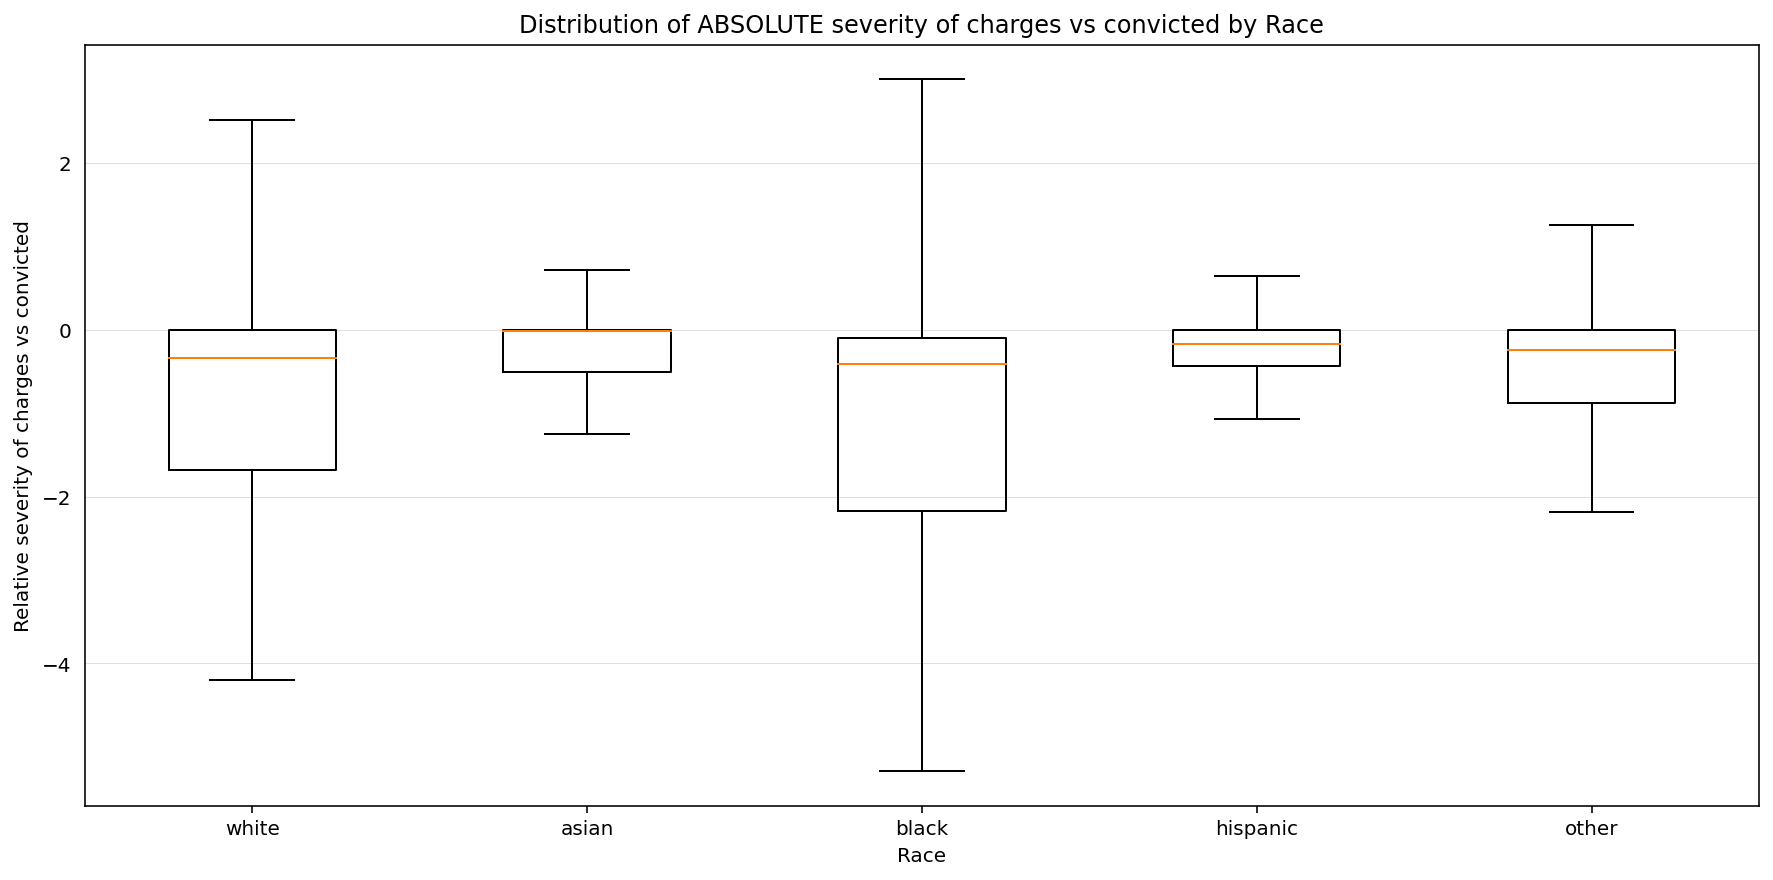

In [ ]:
# Boxplots

white = regression[regression["race"] == "White"]['case_DELTA_ms']
black = regression[regression["race"] == "Black"]['case_DELTA_ms']
asian = regression[regression["race"] == "Asian"]['case_DELTA_ms']
hispanic = regression[regression["race"] == "Hispanic"]['case_DELTA_ms']
other = regression[regression["race"] == "Other"]['case_DELTA_ms']

# Visualize petal length distribution for all species
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of ABSOLUTE severity of charges vs convicted by Race")
plt.xlabel("Race")
plt.ylabel("Relative severity of charges vs convicted")
# Set names as labels for the boxplot
dataset = [
    white,
    asian,
    black,
    hispanic,
    other,
]
ax.boxplot(
    dataset,
    labels=[
        "white",
        "asian",
        "black",
        "hispanic",
        "other",
    ],
    showfliers=False,
)
plt.show()

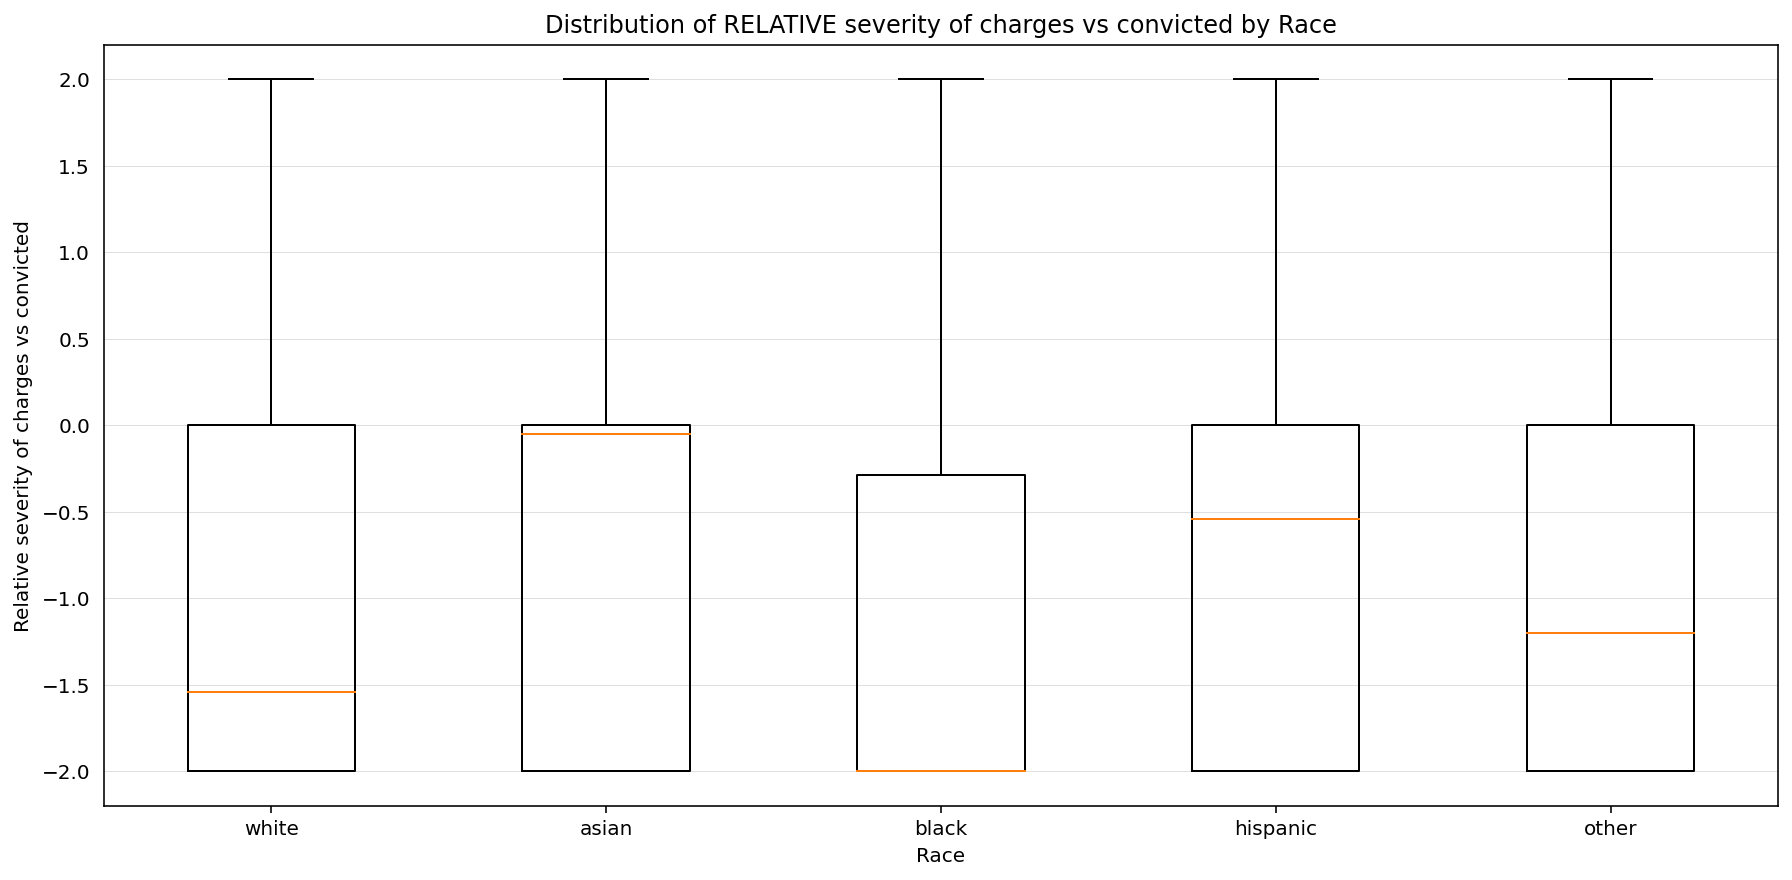

In [ ]:
# Boxplots

white = regression[regression["race"] == "White"]['case_DELTA_ms_rel']
black = regression[regression["race"] == "Black"]['case_DELTA_ms_rel']
asian = regression[regression["race"] == "Asian"]['case_DELTA_ms_rel']
hispanic = regression[regression["race"] == "Hispanic"]['case_DELTA_ms_rel']
other = regression[regression["race"] == "Other"]['case_DELTA_ms_rel']

# Visualize petal length distribution for all species
fig, ax = plt.subplots(figsize=(15, 7))

# Remove y-axis tick marks
ax.yaxis.set_ticks_position("none")
# Add major gridlines in the y-axis
ax.grid(color="grey", axis="y", linestyle="-", linewidth=0.25, alpha=0.5)
# Set plot title
ax.set_title("Distribution of RELATIVE severity of charges vs convicted by Race")
plt.xlabel("Race")
plt.ylabel("Relative severity of charges vs convicted")
# Set names as labels for the boxplot
dataset = [
    white,
    asian,
    black,
    hispanic,
    other,
]
ax.boxplot(
    dataset,
    labels=[
        "white",
        "asian",
        "black",
        "hispanic",
        "other",
    ],
    showfliers=False,
)
plt.show()
# ????????????????????????????????

In [ ]:
# prior record agains race, and scatter of prior record vs deltas

In [ ]:
regression.loc[regression.case_DELTA_ms_rel.isna()]

,case_id,CL_Rank,case_DELTA_cl,case_DELTA_ms,case_DELTA_cl_perc,case_DELTA_ms_perc,case_DELTA_cl_rel,case_DELTA_ms_rel,key_county_num,key_year,race,sex,court_attorney_type,process_served,prior_record_points,plea_code,def_zip_address,usps_zip_pref_city,year,COUNTY,total


# by COUNTY / DISTRICT COURT

In [ ]:
# Panel OLS - relative drop in MIN SENTENCE RANK
# regression_multiindex = regression.set_index(['key_county_num', 'key_year'])


# from linearmodels import PanelOLS
# mod = PanelOLS.from_formula('case_DELTA_ms_rel ~ 1 + race + sex + prior_record_points + court_attorney_type + TimeEffects + EntityEffects',
#                             data=regression_multiindex)
# mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

In [ ]:
# Panel OLS - relative drop in CLASS RANK

# from linearmodels import PanelOLS
# mod = PanelOLS.from_formula('case_DELTA_cl_rel ~ 1 + race + sex + prior_record_points + court_attorney_type + TimeEffects + EntityEffects',
#                             data=regression_multiindex)
# mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)